<a href="https://colab.research.google.com/github/AliPakzad/Daily_Climate_Forecasting_Project/blob/main/primary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌤️ Daily Climate Forecasting Project (Delhi, India)


## Introduction

This notebook analyzes and models the **Daily Climate Time Series Dataset** from Delhi, India — available on [Kaggle](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data).  
The dataset provides daily observations of **mean temperature**, **humidity**, **wind speed**, and **mean pressure** from **January 2013 to April 2017**.

---

### 🎯 Project Objective
The main goal is to **forecast the daily mean temperature** using deep learning–based time series models implemented in the **Darts** library.

---

### 🧠 Models Used
Four different models are developed and compared:
- **DeepAR**
- **N-BEATS**
- **Temporal Fusion Transformer (TFT)**
- **DeepTCN**

---

### ⚙️ Methodology
For each model:
- Models are optimized for **forecast horizon = 10 days**
- Evaluation metrics such as **MAE** and **MAPE** are computed on the validation set.
- A **backtesting** procedure is also performed to assess temporal prediction stability.
- The effect of adding different **covariates** on forecasting performance is analyzed:
  - **Past covariates:** humidity, wind speed, mean pressure  
  - **Future covariates:** month and season (derived from the `date` column)

---

Finally, all four models are compared to study:
- The impact of adding past and future covariates  
- The relative forecasting performance of DeepAR, N-BEATS, TFT, and DeepTCN  

This notebook provides a complete workflow for multivariate time series forecasting and model comparison using real-world climate data.


In [ ]:
!pip install -U darts

We import all the necessary libraries:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from darts.metrics import mae, mape

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, NBEATSModel, TFTModel, TCNModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.likelihood_models.torch import GaussianLikelihood
from darts.utils.missing_values import fill_missing_values
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from pytorch_lightning.callbacks import EarlyStopping

# turn off warnings for final notebook
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/daily-climate-time-series-data


In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


In [ ]:
df = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv")
df_test = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv")

## EDA

In [ ]:
print(df.isna().sum())


date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


We do not have any missing values.

In [ ]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


Lets check datatypes of different columns:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


Statistical summary of the DataFrame:

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333


## 📊 Data Visualization

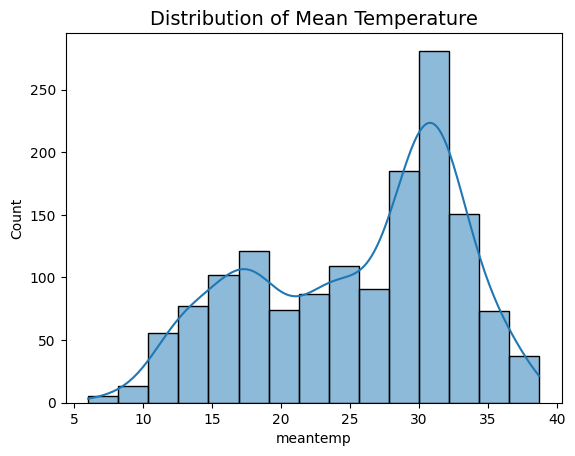

In [ ]:
plt.title('Distribution of Mean Temperature', fontsize=14)

sns.histplot(data= df, x='meantemp', kde=True)

plt.show()

The histogram and density plot reveal that most daily mean temperatures fall between 25°C and 35°C, with a peak around 30°C. This indicates a warm climate trend in the dataset, with relatively few extreme cold or hot days.

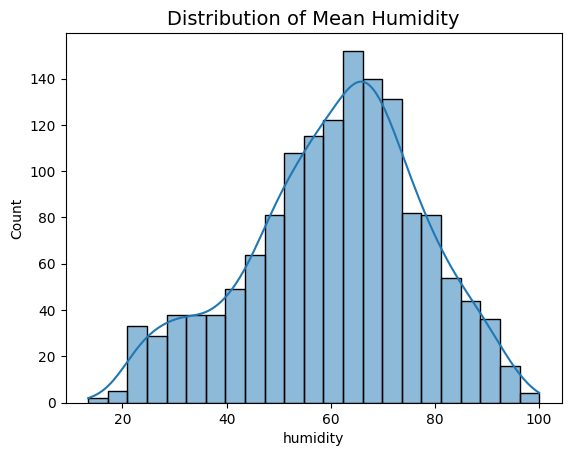

In [ ]:
plt.title('Distribution of Mean Humidity', fontsize=14)

sns.histplot(data= df, x='humidity', kde=True)

plt.show()

This histogram plot illustrates the distribution of daily mean humidity in Delhi, India, from January 2013 to April 2017. Most values fall between 50% and 70%, peaking around 65%, indicating a generally humid climate throughout the observed period.

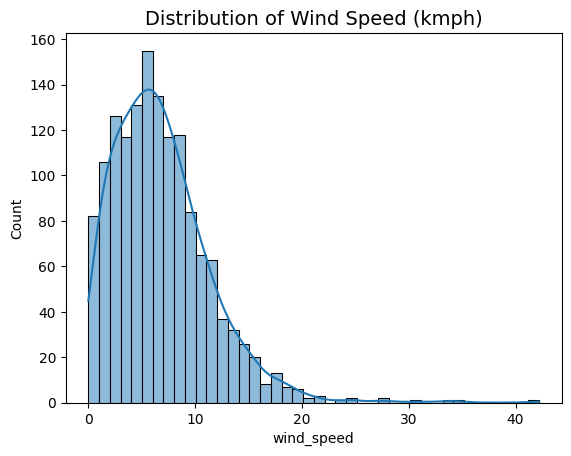

In [ ]:
plt.title('Distribution of Wind Speed (kmph)', fontsize=14)

sns.histplot(data= df, x='wind_speed', kde=True)

plt.show()

This histogram represents the distribution of daily wind speed in Delhi, India, from January 2013 to April 2017. Most values are concentrated around 5 kmph, indicating generally calm wind conditions throughout the period.

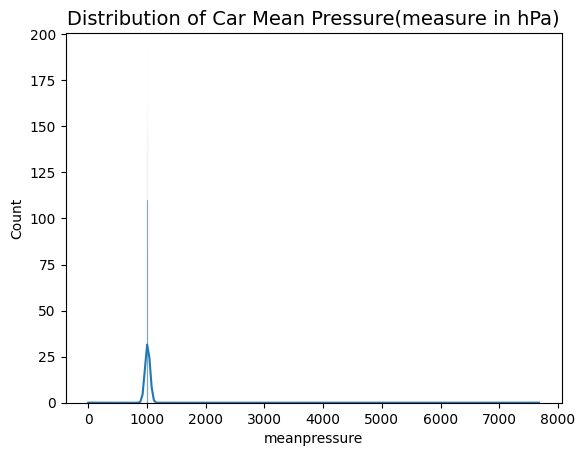

In [ ]:
plt.title('Distribution of Car Mean Pressure(measure in hPa)', fontsize=14)

sns.histplot(data= df, x='meanpressure', kde=True)

plt.show()

This histogram and density plot display the distribution of daily mean atmospheric pressure in Delhi, India, from January 2013 to April 2017. Most values cluster around 1008 hPa, reflecting stable pressure conditions typical of a low-altitude urban climate.

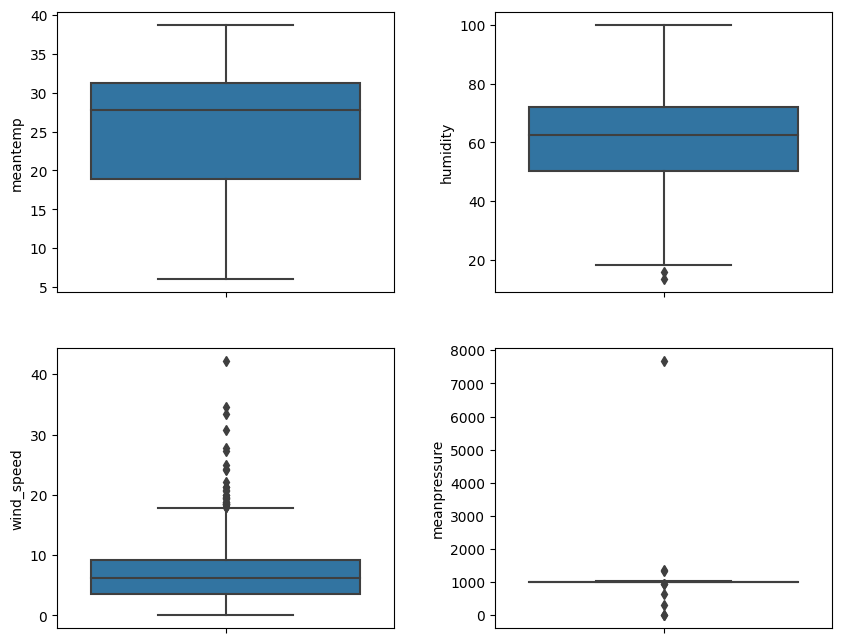

In [ ]:
fig = plt.figure(figsize = (10, 8))

plt.tight_layout()
plt.subplots_adjust(wspace=0.3,
                    hspace=0.2)

cols = df.columns[1:]

for i in range(len(cols)):
  plt.subplot(2,2,i+1)
  sns.boxplot(data= df, y = df[cols[i]])

plt.show()

The box plots summarize the distribution of Delhi's daily climate features from January 2013 to April 2017. Mean temperature and humidity show relatively symmetric distributions, while wind speed and pressure exhibit notable outliers, indicating occasional extreme weather conditions.

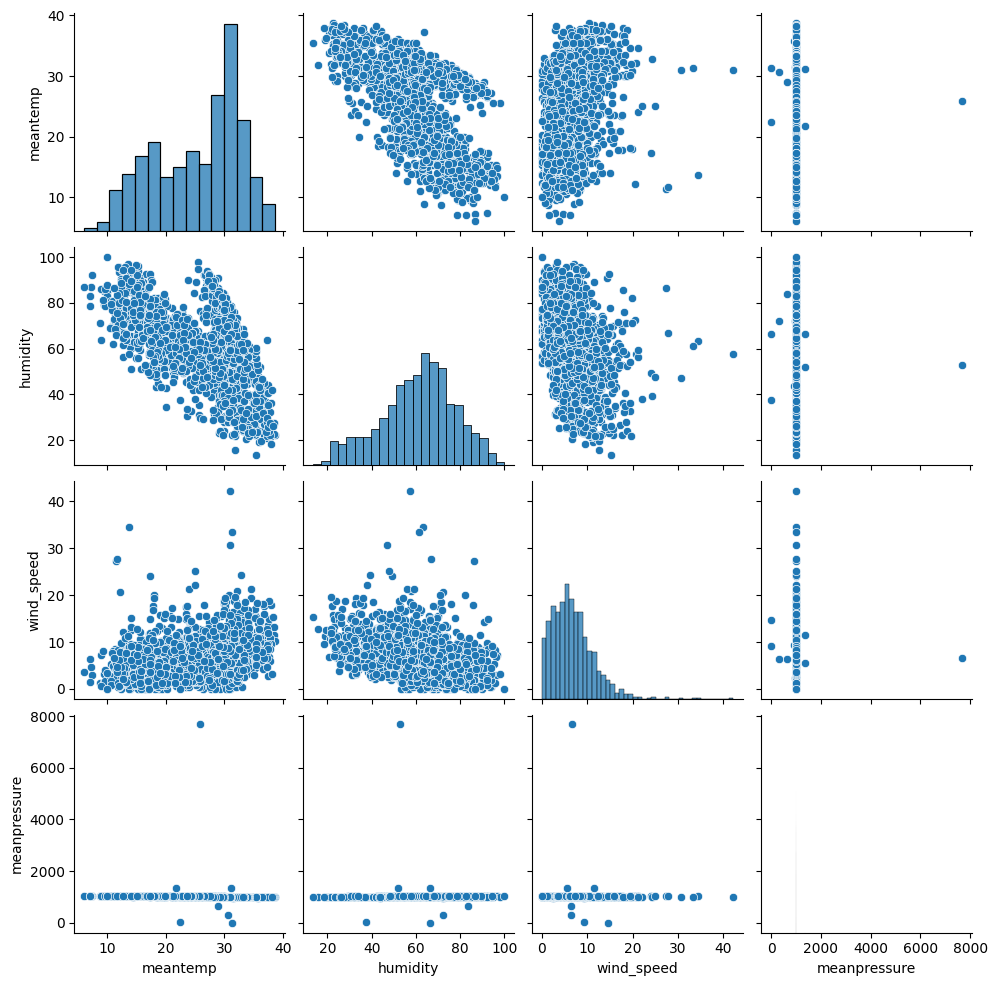

In [ ]:
sns.pairplot(df)
plt.show()

The pair plot highlights key relationships among Delhi’s climate features from January 2013 to April 2017. Mean temperature shows a moderate negative correlation with humidity, indicating that cooler days tend to be more humid. Wind speed appears largely uncorrelated with other features. Mean pressure shows weak associations overall, though further analysis after outlier removal reveals stronger links. These insights help identify potential covariates for forecasting models.

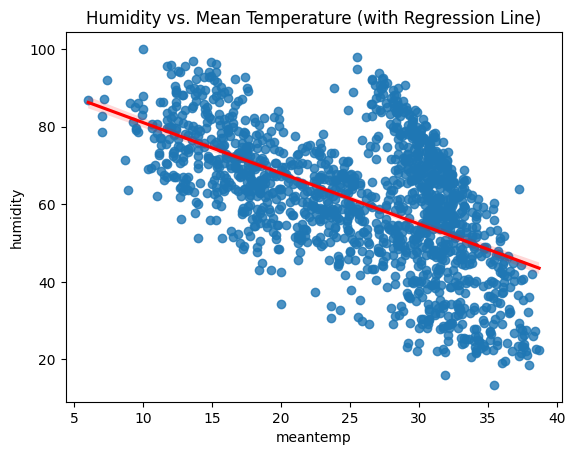

In [ ]:
sns.regplot(data=df, x='meantemp' , y='humidity', line_kws={"color": "red"})
plt.title("Humidity vs. Mean Temperature (with Regression Line)")

plt.show()

The regression plot confirms a moderate negative correlation between mean temperature and humidity in Delhi’s daily climate data (2013–2017). As temperatures rise, humidity tends to decrease, reflecting the region’s dry summer conditions and reinforcing earlier statistical findings.

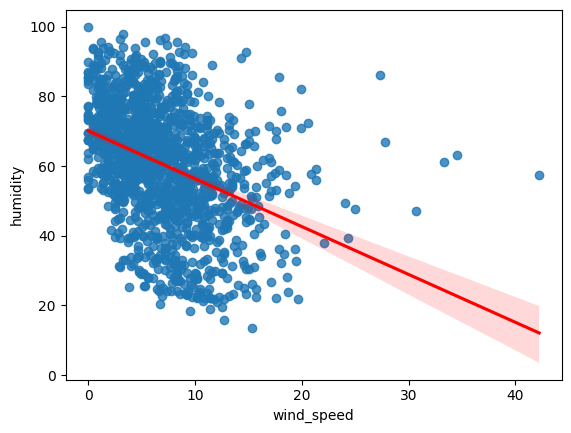

In [ ]:
sns.regplot(data=df, x='wind_speed' , y='humidity', line_kws={"color": "red"})
plt.show()

The regression plot reveals a moderate negative correlation between wind speed and humidity in Delhi’s daily climate data (2013–2017). As wind speed increases, humidity tends to decrease—suggesting that stronger winds may be associated with drier atmospheric conditions.

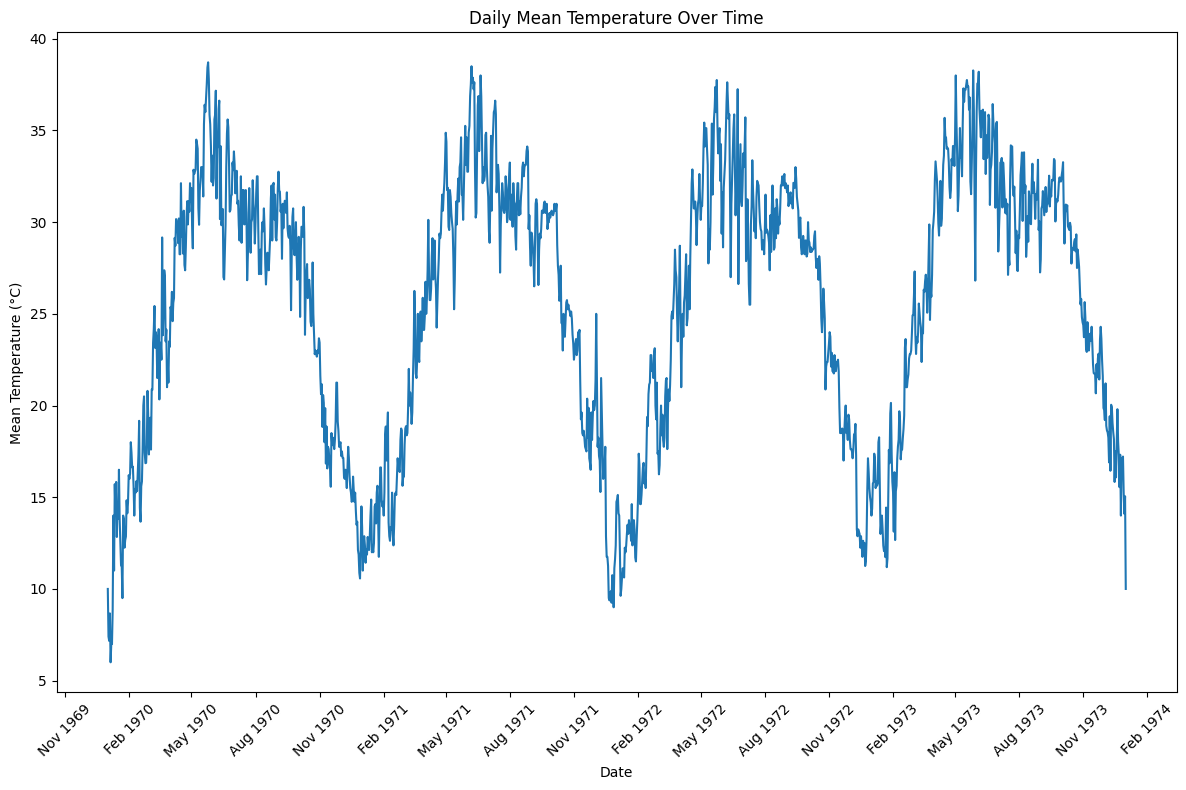

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data=df, x='date', y='meantemp')

ax = plt.gca() #get current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  #show every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45)
plt.title("Daily Mean Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Mean Temperature (°C)")
plt.tight_layout()
plt.show()

### 🌡️ Analysis of Mean Temperature Trend Over Time

The line plot illustrates seasonal fluctuations in Delhi’s daily mean temperature from January 2013 to April 2017. Clear annual cycles are visible, with temperature peaks during summer months and troughs during winter.

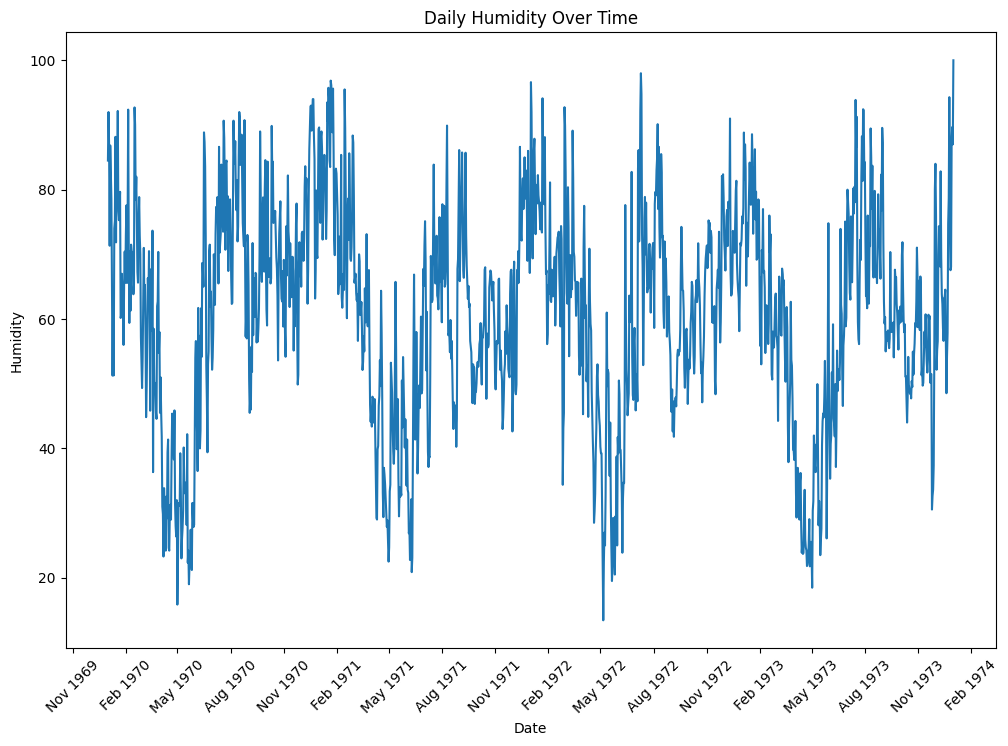

In [ ]:
fig = plt.figure(figsize=(12,8))

ax = plt.gca() #get current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

sns.lineplot(data=df, x='date', y='humidity')
plt.xticks(rotation=45)
plt.title("Daily Humidity Over Time")
plt.xlabel("Date")
plt.ylabel("Humidity")

plt.show()

### 💧 Humidity Trend Analysis

This plot shows how Delhi’s daily humidity changes over time. Humidity is lowest around April and May, when the weather is hottest and driest. It increases during the rainy season (June to September) and also stays high in cooler months like November to February. These changes follow a clear seasonal pattern and help explain why humidity and temperature move in opposite directions.

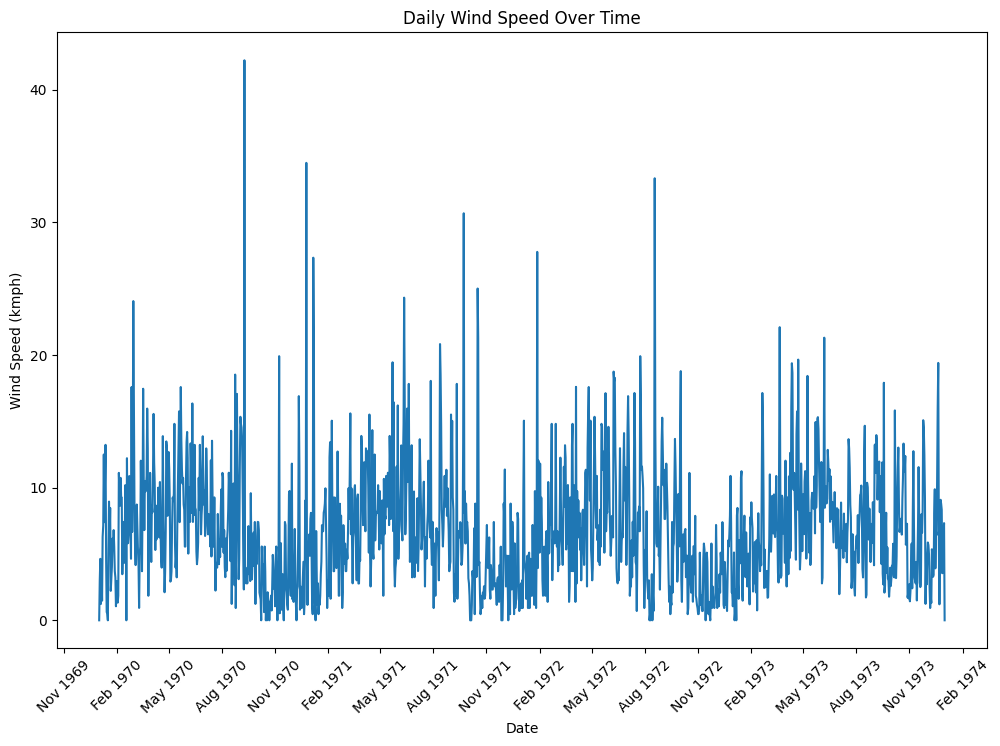

In [ ]:
fig = plt.figure(figsize=(12,8))

ax = plt.gca() #get current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

sns.lineplot(data=df, x='date', y='wind_speed')
plt.xticks(rotation=45)
plt.title("Daily Wind Speed Over Time")
plt.xlabel("Date")
plt.ylabel("Wind Speed (kmph)")

plt.show()

### 💨 Wind Speed Trend Analysis

This plot shows how Delhi’s **daily wind speed (km/h)** changed from late 2012 to early 2017. Wind speed fluctuates throughout the year, with occasional peaks and dips. While no strong seasonal pattern is immediately obvious, the series appears to have **mild seasonal patterns**, where higher wind speeds are often observed during certain months, possibly related to monsoon or pre-monsoon periods.  
Overall, the wind speed remains mostly between **0 and 20 km/h**, with a few outliers reaching above 40 km/h.

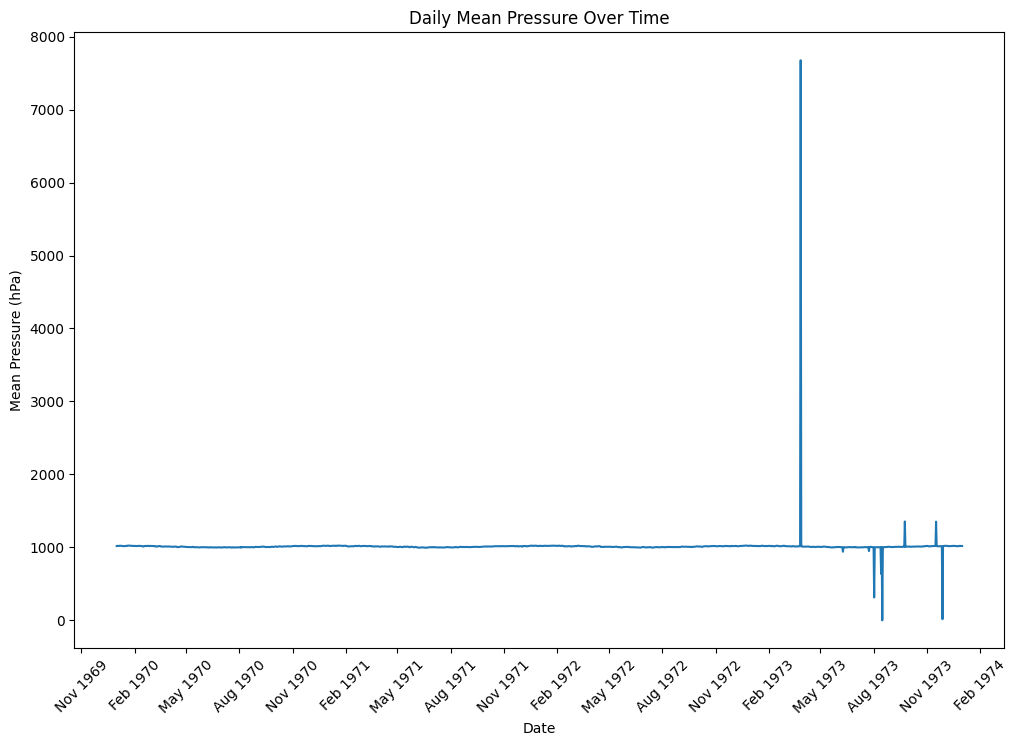

In [ ]:
fig = plt.figure(figsize=(12,8))

ax = plt.gca() #get current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

sns.lineplot(data=df, x='date', y='meanpressure')
plt.xticks(rotation=45)
plt.title("Daily Mean Pressure Over Time")
plt.xlabel("Date")
plt.ylabel("Mean Pressure (hPa)")

plt.show()

### Analysis of Mean Air Pressure Over Time

The plot of daily mean air pressure shows that most values stay within the normal atmospheric range (around **950–1050 hPa**).  
However, a few extreme spikes and negative readings are clearly visible — especially around **early 2016** — which are physically unrealistic and indicate **data entry or measurement errors**.  
These anomalies are considered **outliers**, since atmospheric pressure on Earth typically ranges between **870 hPa (very low pressure in strong cyclones)** and **1085 hPa (record high pressure)**.  
In the following sections, we will clean the dataset by removing these points and replot the pressure series for a clearer analysis.


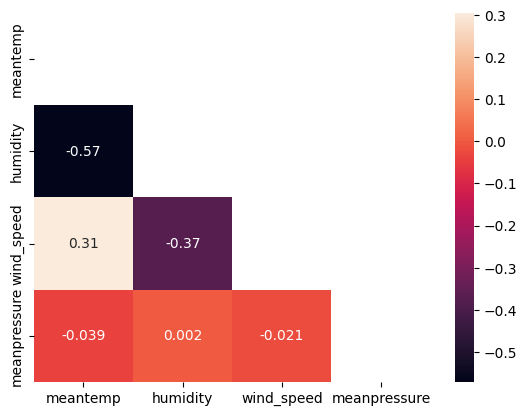

In [ ]:
#fig = plt.figure(figsize=(10,10))
numeric_df = df[df.describe().columns]

matrix = np.triu(numeric_df.corr())
sns.heatmap(numeric_df.corr().round(3), mask=matrix, annot=True)

plt.show()

### 🔥 Correlation Heatmap Insight
The heatmap visualizes pairwise correlations among Delhi’s daily climate features (2013–2017). It reveals a moderate negative correlation between mean temperature and humidity (-0.57), and a weak positive correlation between temperature and wind speed (0.31). These relationships help guide feature selection for forecasting models.

We must convert `date` column into datetime format:

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

We create new columns:

In [ ]:
df['day_of_month'] = df['date'].apply(lambda x: x.day)

df['month'] = df['date'].apply(lambda x: x.month)

df['year'] = df['date'].apply(lambda x: x.year)

In [ ]:
# mapping month to season
def get_season(month_num):
    if month_num in [12, 1, 2]:
        return "winter"
    elif month_num in [3, 4, 5]:
        return "spring"
    elif month_num in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

df["season"] = df["month"].apply(get_season)

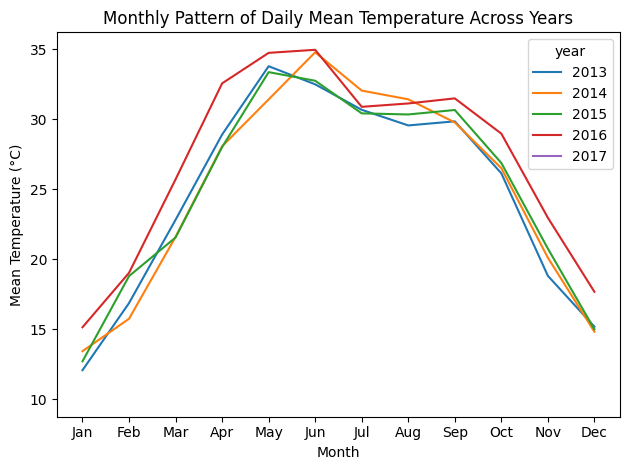

In [ ]:
#plt.figure(figsize=(12,8))
sns.lineplot(data = df, x='month', y='meantemp', hue ="year", ci= None, palette='tab10')

plt.title("Monthly Pattern of Daily Mean Temperature Across Years")
plt.xticks(range(1,13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.xlabel("Month")
plt.ylabel("Mean Temperature (°C)")
plt.tight_layout()
plt.show()

### 📆 Monthly Temperature Pattern Insight

This plot compares the monthly pattern of daily mean temperature across five years in Delhi. All years show a consistent seasonal trend: temperatures rise from January to June, peak in summer, and decline toward December. The year 2016 recorded the highest summer temperatures, while 2013 started with the coolest January. This seasonal consistency supports the reliability of the dataset and highlights year-to-year variations in summer intensity.


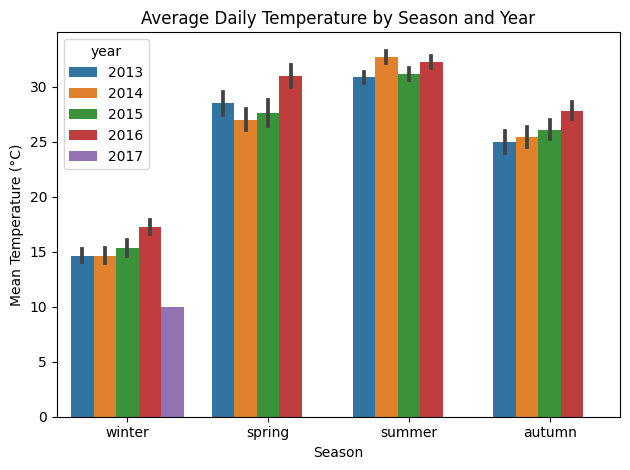

In [ ]:
plt.title("Average Daily Temperature by Season and Year")

sns.barplot(data=df, x='season', y='meantemp', hue='year', palette='tab10')

plt.xlabel("Season")
plt.ylabel("Mean Temperature (°C)")
plt.tight_layout()
plt.show()

This bar chart shows how average daily temperatures vary by season across five years. Summer is consistently the hottest, winter the coolest, and spring slightly warmer than autumn. The seasonal pattern is stable, with minor year-to-year differences.

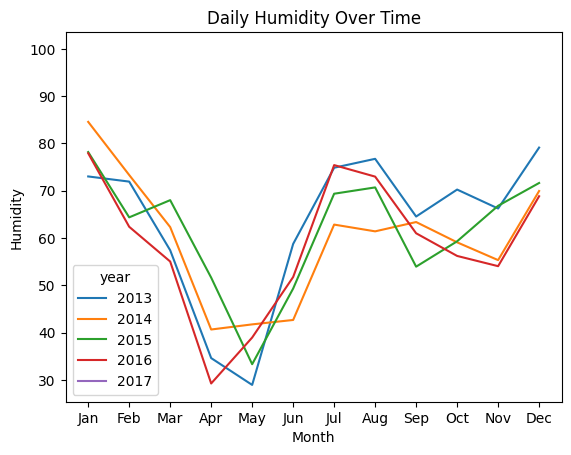

In [ ]:
sns.lineplot(data=df, x='month', y='humidity', hue ="year", ci= None, palette='tab10')

plt.title("Daily Humidity Over Time")
plt.xlabel("Month")
plt.xticks(range(1,13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel("Humidity")

plt.show()

### 💧 Monthly Humidity Pattern Insight

This plot shows how daily humidity levels vary month by month across five years in Delhi. A clear seasonal pattern emerges: humidity tends to be lowest in April and May, then rises sharply during the rainy months of June to August. Winter months (November to February) also show relatively high humidity, likely due to cooler temperatures and fog. While the overall pattern is consistent, some years—like 2014—exhibit sharper drops or fluctuations, suggesting year-specific anomalies or weather events.

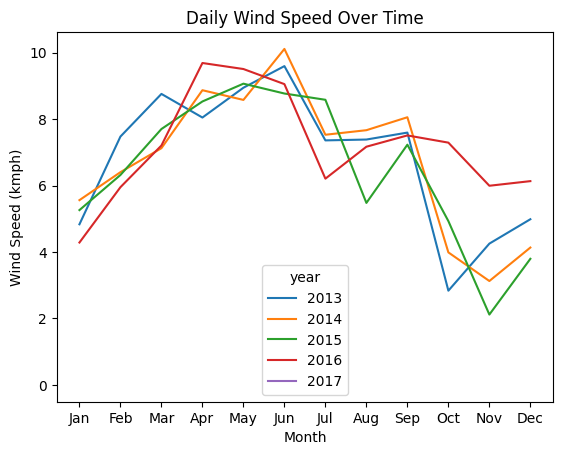

In [ ]:
sns.lineplot(data=df, x='month', y='wind_speed', hue ="year", ci= None, palette='tab10')

plt.title("Daily Wind Speed Over Time")
plt.xlabel("Month")
plt.xticks(range(1,13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel("Wind Speed (kmph)")

plt.show()

### 💨 Monthly Wind Speed Pattern Insight

This plot shows how daily wind speed varies across months and years in Delhi. While wind speed tends to rise from winter to late spring and decline toward autumn, the overall pattern is irregular and lacks strong seasonal consistency. Year-to-year fluctuations—especially in summer months—suggest that wind speed may be influenced more by short-term weather events than by stable seasonal cycles.

## Dealing with Outliers

We previously identified outliers in the mean pressure and wind speed columns using boxplots and time series plots. These extreme values—especially the unrealistic spikes and negative readings—can distort patterns and correlations. In this section, we remove them to uncover cleaner relationships with the target variable: daily mean temperature.

In [ ]:
Q1 = df['meanpressure'].quantile(0.25)
Q3 = df['meanpressure'].quantile(0.75)
IQR = Q3 - Q1

iqr_lower_bound = Q1 - 1.5 * IQR
iqr_upper_bound = Q3 + 1.5 * IQR

print("Lower Bound:", iqr_lower_bound)
print("Upper Bound:", iqr_upper_bound)

Lower Bound: 981.5335408834585
Upper Bound: 1034.991717575188


> The hard bounds `lower=870` and `upper=1085` hPa are chosen from domain knowledge about atmospheric pressure: typical sea-level pressure is ≈1013 hPa and documented global extremes lie roughly near 870 hPa (very deep cyclones) and ~1085 hPa (record high pressures). These physical bounds act as a safety check against impossible measurements.
>
> In contrast, the dataset IQR method produced sample-specific bounds (`lower≈981.53`, `upper≈1034.99`) which are useful to flag local statistical outliers relative to this dataset’s spread. Both approaches are complementary: the IQR detects values that are extreme for this sample, while the physical bounds prevent keeping values that are physically impossible.
>
> The `describe()` output showed `min = -3.04` and `max = 7679.33`, which are not physically plausible for atmospheric pressure and therefore likely measurement or recording errors. Such extreme values (even if very few) drastically distort scaling and model training and should be masked (set to `NaN`) and then imputed (e.g. by interpolation).
>
> Example mask (produce a cleaned column and keep original):

In [ ]:
# mask values outside physical and/or IQR bounds, then interpolate
df['meanpressure_cleaned'] = df['meanpressure'].mask(
    (df['meanpressure'] < max(iqr_lower_bound, 870)) |
    (df['meanpressure'] > min(iqr_upper_bound, 1085))
).interpolate(limit_direction='both')

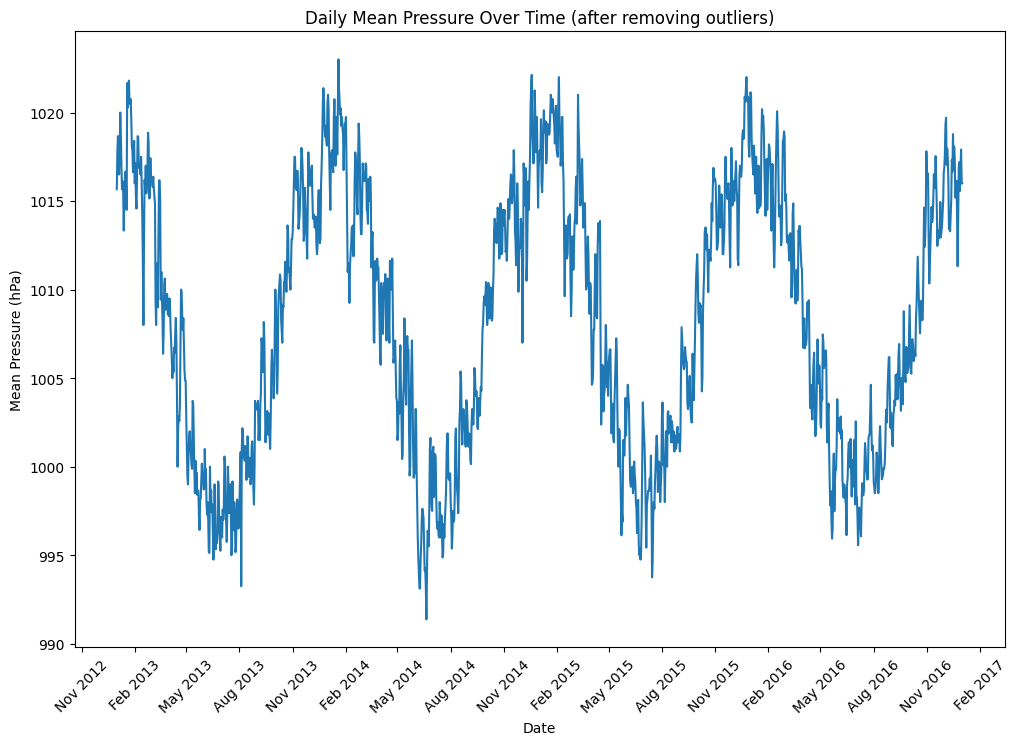

In [ ]:
fig = plt.figure(figsize=(12,8))

ax = plt.gca() #get current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

sns.lineplot(data=df, x='date', y='meanpressure_cleaned')
plt.xticks(rotation=45)
plt.title("Daily Mean Pressure Over Time (after removing outliers)")
plt.xlabel("Date")
plt.ylabel("Mean Pressure (hPa)")

plt.show()

### 🌬️ Mean Pressure After Outlier Removal

This cleaned time series now fluctuates consistently between ~990–1020 hPa, revealing a clear seasonal, annually repeating pattern that was previously obscured by extreme erroneous values. Removing the impossible spike near 8000 hPa and the negative readings eliminated distortion in the y-scale, improved visual interpretability, and prevented bias in statistical analysis. We will use this cleaned pressure series as past covariates to help forecast daily mean temperature in our time series model.

In [ ]:
# cleaning wind speed
q99 = df["wind_speed"].quantile(0.99)
df["wind_speed_cleaned"] = df["wind_speed"].clip(lower=0, upper=q99)

# checking statistics of cleaned columns
print(df[["meanpressure_cleaned", "wind_speed_cleaned"]].describe())

       meanpressure_cleaned  wind_speed_cleaned
count           1462.000000         1462.000000
mean            1008.249852            6.736141
std                7.437428            4.272229
min              991.375000            0.000000
25%             1001.625000            3.475000
50%             1008.563492            6.221667
75%             1014.875000            9.238235
max             1023.000000           19.912500


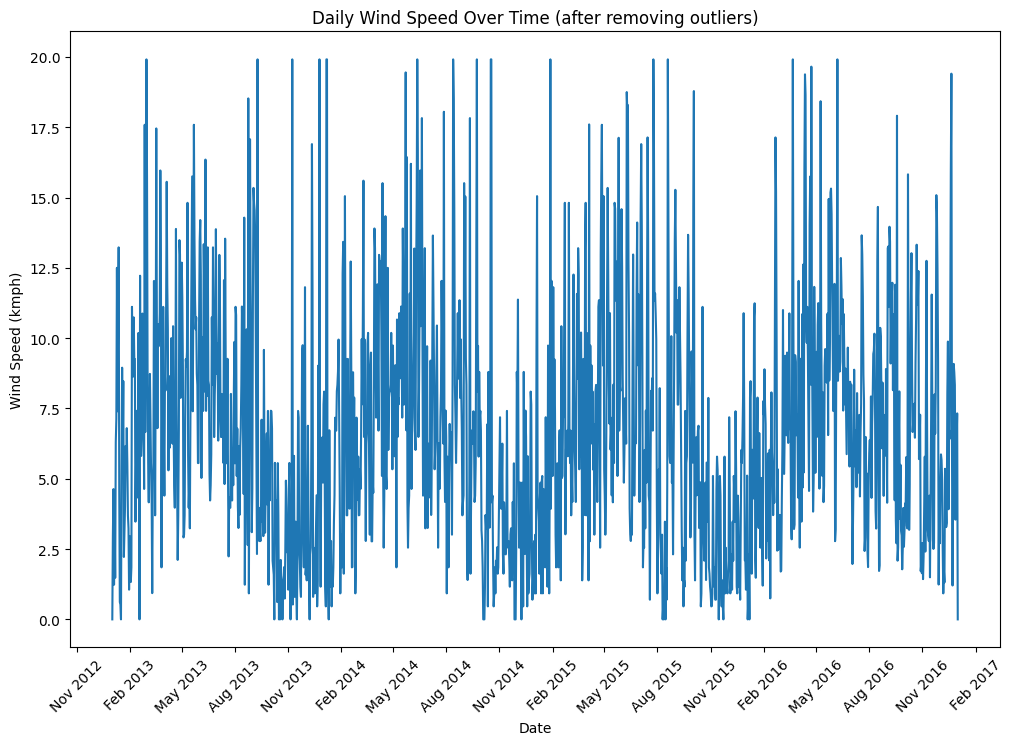

In [ ]:
fig = plt.figure(figsize=(12,8))

ax = plt.gca() #get current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

sns.lineplot(data=df, x='date', y='wind_speed_cleaned')
plt.xticks(rotation=45)
plt.title("Daily Wind Speed Over Time (after removing outliers)")
plt.xlabel("Date")
plt.ylabel("Wind Speed (kmph)")

plt.show()

### 💨 Wind Speed After Outlier Removal

After clipping extreme values above the 99th percentile, the wind speed series now shows more stable fluctuations within a realistic range. This cleanup removed sharp spikes that distorted the scale and masked underlying patterns. The cleaned data reveals more interpretable seasonal variations and will be used as past covariates in our temperature forecasting model.

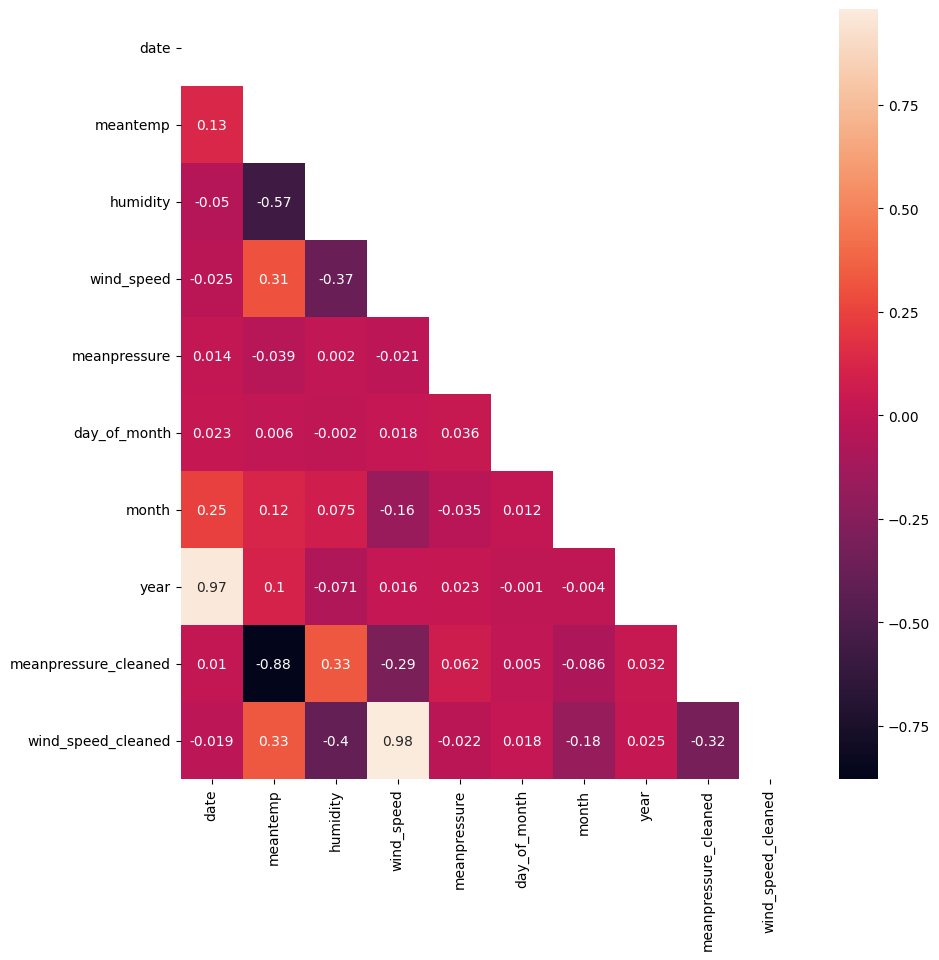

In [ ]:
fig = plt.figure(figsize=(10,10))
numeric_df = df[df.describe().columns]

matrix = np.triu(numeric_df.corr())
sns.heatmap(numeric_df.corr().round(3), mask=matrix, annot=True)

plt.show()

### 📊 Correlation Matrix Insight

This heatmap highlights how outlier removal can dramatically improve feature relevance. The cleaned pressure column (meanpressure_cleaned) shows a strong negative correlation with mean temperature (-0.88), compared to the original pressure column’s near-zero correlation (-0.039). This transformation reveals a much stronger covariate for temperature forecasting and confirms the value of preprocessing in time series modeling.

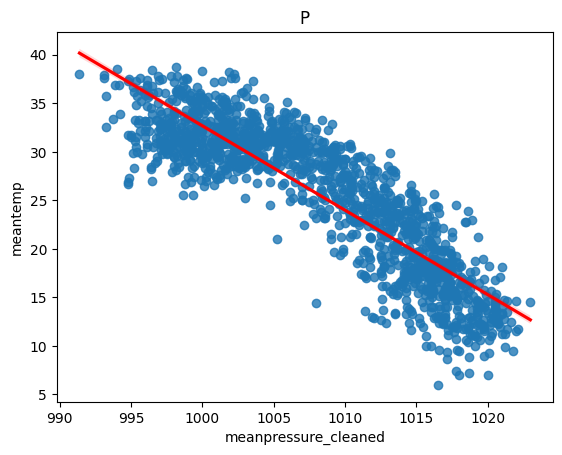

In [ ]:
sns.regplot(data=df, x='meanpressure_cleaned' , y='meantemp', line_kws={"color": "red"})
plt.title(f'P')

plt.show()

## Data Prepration

Darts library works with `TimeSeries` objects. So we covert `meantemp` column to `TimeSeries`:

In [ ]:
# Converting train and test to timeseries objects, so that darts can use it. we use days as a frequency
meantemp_timeseries = TimeSeries.from_dataframe(df, time_col="date", value_cols="meantemp", freq="D")  # main series

#test_series  = TimeSeries.from_dataframe(df_test,  time_col="date", value_cols="meantemp", freq="D")

We divide both the target time series into training and validation parts. The first 80% of the series is used for training, and the remaining 20% is reserved for validation and model evaluation.

In [ ]:
# --- Train/Test split ---
target_train, target_val = meantemp_timeseries.split_after(0.8)

We normalize the target series (mean temperature) using a scaler trained only on the training set to prevent data leakage. The same scaler is then applied to validation and full time series data. This ensures consistent scaling during model training, prediction, and backtesting.

In [ ]:
# --- Normalization ---
target_scaler = Scaler()

# to avoid data leakage we train scaler on training data and only transform the test data
target_train_scaled = target_scaler.fit_transform(target_train)
target_val_scaled   = target_scaler.transform(target_val)
#target_test_scaled  = target_scaler.transform(test_series)

# we also need full time series of target for prediction phase and for backtesting
full_target_scaled =  target_scaler.transform(meantemp_timeseries)

## Creating Covariates for Forecasting

### Past Covariates

We construct past covariates from humidity, cleaned wind speed, and cleaned pressure columns. These variables are treated as past covariates because their future values are not known at prediction time. Unlike calendar features such as month or season—which can be deterministically computed ahead—these weather metrics depend on real-time measurements and cannot be forecasted independently. Including them as past covariates helps the model learn temporal dependencies and improves temperature prediction accuracy.

In [ ]:
past_cov = TimeSeries.from_dataframe(df, time_col="date", value_cols=['humidity',	'wind_speed_cleaned',	'meanpressure_cleaned'], freq="D")  # past cov

past_cov.to_dataframe().head()

,humidity,wind_speed_cleaned,meanpressure_cleaned
date,,,
2013-01-01,84.500000,0.000000,1015.666667
2013-01-02,92.000000,2.980000,1017.800000
2013-01-03,87.000000,4.633333,1018.666667
2013-01-04,71.333333,1.233333,1017.166667
2013-01-05,86.833333,3.700000,1016.500000


### Future Covariates

We construct future covariates using one-hot encoded month and season features derived from the date column. These variables are known ahead of time and follow a fixed calendar pattern, making them suitable as future covariates. Including them helps the model capture seasonal and monthly effects in temperature forecasting.

In [ ]:
month_ts = datetime_attribute_timeseries(
    meantemp_timeseries, attribute="month", one_hot=True
)

In [ ]:
# set `date` column as index of dataframe
df = df.set_index('date', drop=False)

# convert season column to one-hot encoding
df =pd.get_dummies(df, columns=['season'])

season_ts = TimeSeries.from_dataframe(df, time_col="date", value_cols=['season_autumn',	'season_spring',	'season_summer',	'season_winter'], freq="D")  # season cov

In [ ]:
future_cov = month_ts.stack(season_ts)
print("Stacked future_cov shape:", future_cov.n_components, "components, length:", len(future_cov.time_index))

Stacked future_cov shape: 16 components, length: 1462


In [ ]:
future_cov.to_dataframe().head()

,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,season_autumn,season_spring,season_summer,season_winter
date,,,,,,,,,,,,,,,,
2013-01-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2013-01-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2013-01-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2013-01-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2013-01-05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Split Covariates

In [ ]:
# split future covariates into train and validation
future_cov_train, future_cov_val = future_cov.split_after(0.8)

# split past covariates into train and validation
past_cov_train, past_cov_val = past_cov.split_after(0.8)

Future covariates are already normalized(One-Hot Encoded), but we need to normalize past covariates:

In [ ]:
cov_scaler = Scaler()

past_cov_train_scaled = cov_scaler.fit_transform(past_cov_train)
past_cov_val_scaled   = cov_scaler.transform(past_cov_val)

full_past_cov_scaled = cov_scaler.transform(past_cov)

### ⚙️ Notes on Covariate Compatibility

Before building the models, it’s important to understand which types of covariates each model supports.
The table below summarizes this information based on the Darts library documentation:

| Model | Supports Past Covariates | Supports Future Covariates | Notes |
|:------|:-------------------------:|:---------------------------:|:------|
| **DeepAR** | ❌ | ✅ | Uses autoregressive structure; relies on known future inputs. |
| **N-BEATS** | ✅ | ❌ | Fully-connected blocks; no access to future covariates. |
| **TFT** | ✅ | ✅ *(mandatory)* | Requires future covariates; past are optional. |
| **DeepTCN** | ✅ | ❌ | Causal convolutions restrict access to future data. |


## DeepAR Forecasting

#### Hyperparameter Tuning

This cell performs hyperparameter tuning for the DeepAR model using grid search. It tests multiple combinations of input window size, hidden layer dimensions, number of RNN layers, and dropout rates to find the best configuration for forecasting mean temperature with a horizon of 10 days. The model is evaluated using MAE on validation data, and the best-performing setup is selected for further use.

In [ ]:
# hyperparameters that we want to tune
param_grid = {
    "input_chunk_length": [20, 30, 60],       # lookback window (days)
    "hidden_dim": [32, 64],                   # RNN hidden units
    "n_rnn_layers": [1, 2],                   # number of recurrent layers
    "dropout": [0, 0.2],                 # dropout rate

    # Fixed (base) kwargs for all combination
    # these args are constant across the gridsearch trials
    "model": ["LSTM"],
    "batch_size": [16],
    "n_epochs": [20],
    "optimizer_kwargs": [{"lr": 1e-3}],
    "random_state": [42],
    "training_length": [90],
    "likelihood": [GaussianLikelihood()],
    "save_checkpoints": [True],
    #"pl_trainer_kwargs": [{"callbacks": [early_stop_callback]}]   # optional callbacks for early stopping/checkpoint
}


# running gridsearch - expanding window mode
best_model, best_params, metric_score = RNNModel.gridsearch(
    parameters= param_grid,
    forecast_horizon = 10,
    series = target_train_scaled,
    stride= 10,
    start= 0.8,
    metric= mae,   # metric to optimize during grid search
    # n_jobs=-1,  # Use all available CPU cores
)

In [ ]:
print("Best hyperparameters:", best_params)

print("Best validation MAE (Scaled):", metric_score)

Best hyperparameters: {'input_chunk_length': 20, 'hidden_dim': 32, 'n_rnn_layers': 1, 'dropout': 0, 'model': 'LSTM', 'batch_size': 16, 'n_epochs': 20, 'optimizer_kwargs': {'lr': 0.001}, 'random_state': 42, 'training_length': 90, 'likelihood': GaussianLikelihood(prior_mu=None, prior_sigma=None, beta_nll=0.0, prior_strength=1.0), 'save_checkpoints': True}
Best validation MAE (Scaled): 0.07324370300822972


### 1. DeepAR Baseline Model (No Covariates)

We train a DeepAR model using only the scaled mean temperature series, without any covariates. The model is configured with the best hyperparameters found during grid search and trained for 100 epochs. This baseline setup allows us to evaluate the model’s performance using MAE on the validation set before introducing additional features.

In [ ]:
best_params.pop('n_epochs', None)
deepAR_model = RNNModel(**best_params, n_epochs=100, force_reset=True)

In [ ]:
deepAR_model.fit(series= target_train_scaled)

Now we evaluate the tuned model on validation time series:

In [ ]:
preds = deepAR_model.predict(n=len(target_val_scaled), num_samples=50)

# Inverse transform
preds = target_scaler.inverse_transform(preds)

deepar_baseline_mape = mape(target_val, preds)
deepar_baseline_mae  = mae(target_val, preds)

In [ ]:
# Evaluate
print("MAPE:", deepar_baseline_mape)
print("MAE:", deepar_baseline_mae)

MAPE: 41.781619629061765
MAE: 12.902303980651114


The baseline DeepAR model, trained without covariates, showed weak performance with high error rates (MAPE ≈ 42%, MAE ≈ 12.90°C), indicating limited predictive accuracy.

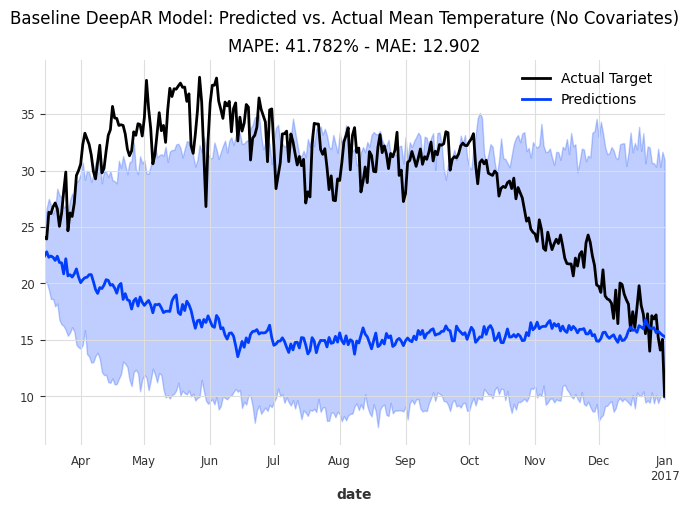

In [ ]:
plt.figure(figsize=(8, 5))

target_val.plot(label ="Actual Target")
preds.plot(label ="Predictions", low_quantile= 0.05, high_quantile = 0.95)

plt.suptitle("Baseline DeepAR Model: Predicted vs. Actual Mean Temperature (No Covariates)")
plt.title(f"MAPE: {deepar_baseline_mape:.3f}% - MAE: {deepar_baseline_mae:.3f}")

plt.show()

This plot compares actual mean temperature values with predictions from the baseline DeepAR model (no covariates). The forecast shows noticeable deviations from the true values, especially during seasonal transitions. With a MAPE of 42% and MAE over 12.9°C, the model struggles to capture underlying patterns, indicating limited predictive power when trained solely on the target series.

###  2. DeepAR Model with Future Covariates (Month & Season)

In this section, we enhance the DeepAR model by incorporating future covariates—specifically, month and season features derived from the date column. These calendar-based variables are known ahead of time and help the model capture seasonal patterns. The goal is to assess whether adding these covariates improves forecasting accuracy compared to the baseline model.

In [ ]:
deepAR_futcov_model = RNNModel(**best_params, n_epochs=100, force_reset=True)

In [ ]:
deepAR_futcov_model.fit(series= target_train_scaled, future_covariates= future_cov_train)

In [ ]:
preds2 = deepAR_futcov_model.predict(n=len(target_val_scaled), future_covariates = future_cov, num_samples=50)

# Inverse transform
preds2 = target_scaler.inverse_transform(preds2)

deepar_futcov_mape = mape(target_val, preds2)
deepar_futcov_mae  = mae(target_val, preds2)

In [ ]:
# Evaluate
print("MAPE:", deepar_futcov_mape)
print("MAE:", deepar_futcov_mae)

MAPE: 7.925375392947778
MAE: 2.194318030613184


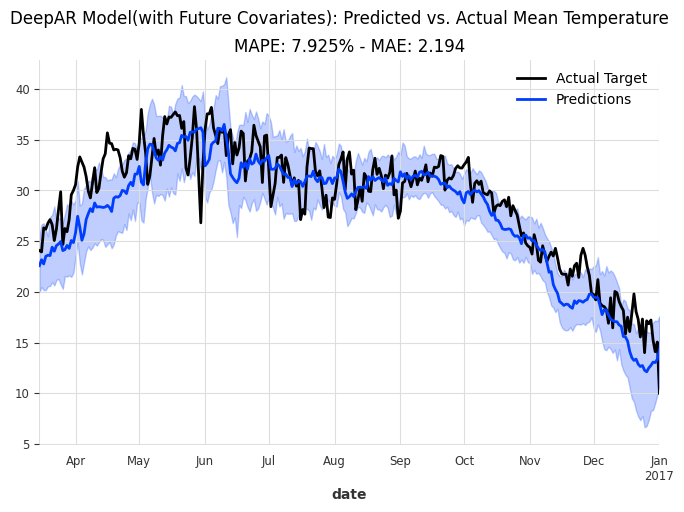

In [ ]:
plt.figure(figsize=(8, 5))

target_val.plot(label ="Actual Target")
preds2.plot(label ="Predictions", low_quantile= 0.05, high_quantile = 0.95)

plt.suptitle("DeepAR Model(with Future Covariates): Predicted vs. Actual Mean Temperature")
plt.title(f"MAPE: {deepar_futcov_mape:.3f}% - MAE: {deepar_futcov_mae:.3f}")

plt.show()

After incorporating future covariates (month and season), the DeepAR model shows a significant improvement in forecasting accuracy. The predicted values closely follow the actual temperature series, with MAPE reduced to ~7.93% and MAE to just 2.2°C. This highlights the importance of calendar-based features in capturing seasonal dynamics and enhancing model performance.

### Backtesting the DeepAR Model

We performed backtesting on the full temperature series using the DeepAR model with future covariates. The scaled MAE of 0.061 indicates strong predictive consistency across multiple forecast windows, confirming the model’s reliability beyond the validation set.

In [ ]:
# Run backtest
mae_score = deepAR_futcov_model.backtest(
    series = full_target_scaled,
    future_covariates = future_cov,
    num_samples=50,
    start= 0.6,
    forecast_horizon= 10,
    stride= 10,
    retrain= True,
    metric = mae
)

In [ ]:
print(f"Backtest Scaled MAE: {mae_score:.3f}")

Backtest Scaled MAE: 0.061


In [ ]:
# Run historical_forecasts
pred_series = deepAR_futcov_model.historical_forecasts(
    series = full_target_scaled,
    future_covariates = future_cov,
    num_samples=50,
    start= 0.6,
    forecast_horizon= 10,
    stride= 10,
    retrain= True,
)

In [ ]:
backtest_forecasts = target_scaler.inverse_transform(pred_series)

# Compute error metrics
mae_backtest = mae(meantemp_timeseries, backtest_forecasts)
mape_backtest = mape(meantemp_timeseries, backtest_forecasts)

print()
print("Backtest results (historical forecasts) over validation period:")
print(f"MAE:  {mae_backtest: .3f}")
print(f"MAPE: {mape_backtest: .3f}")


Backtest results (historical forecasts) over validation period:
MAE:   2.264
MAPE:  8.957


We evaluated the DeepAR model with future covariates using historical forecasts. The model achieved strong performance over the validation period (MAE ≈ 2.26, MAPE ≈ 8.96), confirming its reliability across multiple forecast windows.

Unlike `backtest`, which returns a single aggregated error score over all forecast windows, `historical_forecasts` generates actual prediction series for each window, allowing for visual inspection and detailed error analysis. This makes it ideal for plotting and understanding temporal prediction behavior.

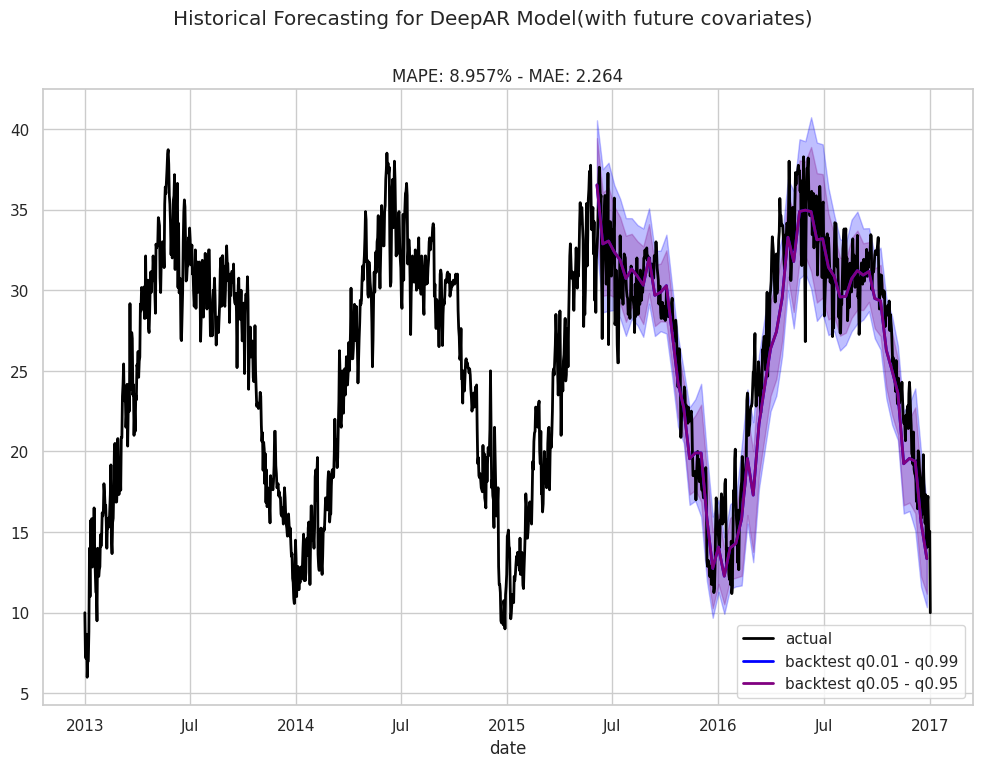

In [ ]:
plt.figure(figsize=(12,8))
meantemp_timeseries.plot(label="actual", color ='black')

backtest_forecasts.plot(label="backtest q0.01 - q0.99", low_quantile=0.01, high_quantile=0.99, color ='blue')
backtest_forecasts.plot(label="backtest q0.05 - q0.95", low_quantile=0.05, high_quantile=0.95, color ='purple')

plt.suptitle("Historical Forecasting for DeepAR Model(with future covariates)")
plt.title(f"MAPE: {mape_backtest:.3f}% - MAE: {mae_backtest:.3f}")

plt.show()

This plot visualizes historical forecasts from the DeepAR model with future covariates (month and season). The predicted temperature intervals closely follow the actual values, with narrow confidence bands and low error metrics (MAPE ≈ 8.96%, MAE ≈ 2.26°C), indicating strong and consistent forecasting performance over time.

## N-BEATS Forecasting

#### Hyperparameter Tuning

We perform hyperparameter tuning for the N-BEATS model using grid search in expanding window mode. The model is evaluated via backtesting on the last 20% of the training set (starting from 80%) to find the best configuration for a 10-day forecast horizon, optimized using MAE.

In [ ]:
param_grid = {
    "input_chunk_length": [30, 60],
    "layer_widths": [128, 256],        # number of neurons that make up each fully connected layer in each block of every stack
    "num_blocks": [1, 2],              # blocks per stack
    "num_layers": [2, 3],              # layers per block
    "dropout": [0.0, 0.1],

    # Fixed (base) kwargs for all combinations
    # these args are constant across the gridsearch trials
    "generic_architecture": [False], #I want to use interpretable architecture
    "output_chunk_length": [10],     # output_chunk_length (forecast_horizon) will be fixed
    "batch_size": [32],
    "n_epochs": [20],
    "optimizer_kwargs": [{"lr": 1e-3}],
    "random_state": [42],
    "save_checkpoints": [True],
}


# running gridsearch - expanding window mode
best_model, best_params, best_metric_score = NBEATSModel.gridsearch(
    parameters=param_grid,
    forecast_horizon = 10,
    series = target_train_scaled,
    stride= 10,
    start=0.8,
    metric = mae,   # metric to optimize during grid search
    # n_jobs=-1,  # Use all available CPU cores
    verbose = True
)

In [ ]:
print("Best hyperparameters:", best_params)

Best hyperparameters: OrderedDict({'output_chunk_shift': 0, 'generic_architecture': False, 'num_stacks': 30, 'num_blocks': 1, 'num_layers': 3, 'layer_widths': 128, 'expansion_coefficient_dim': 5, 'trend_polynomial_degree': 2, 'dropout': 0.1, 'activation': 'ReLU', 'input_chunk_length': 30, 'output_chunk_length': 10, 'batch_size': 32, 'n_epochs': 20, 'optimizer_kwargs': {'lr': 0.001}, 'random_state': 42, 'save_checkpoints': True})


### 1. N-BEATS Baseline Model (No Covariates)

In [ ]:
best_params.pop('n_epochs', None)
nbeats_baseline_model = NBEATSModel(**best_params, n_epochs=100, force_reset=True)

In [ ]:
nbeats_baseline_model.fit(target_train_scaled)

In [ ]:
nbeats_preds = nbeats_baseline_model.predict(n=len(target_val_scaled))

# Inverse transform
nbeats_preds = target_scaler.inverse_transform(nbeats_preds)

In [ ]:
# Evaluate
print("N-BEATS base model MAPE:", mape(target_val, nbeats_preds))
print("N-BEATS base model MAE:", mae(target_val, nbeats_preds))

N-BEATS base model MAPE: 16.441808921221394
N-BEATS base model MAE: 3.8491445692744692


### Visualizing N-BEATS Forecast vs. Actual Target

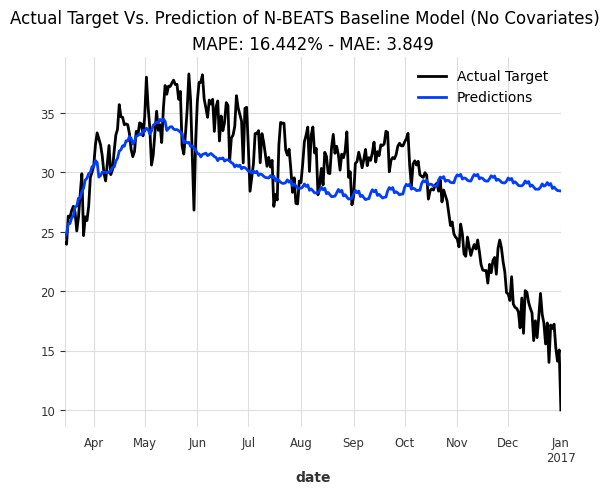

In [ ]:
target_val.plot(label ="Actual Target")
nbeats_preds.plot(label ="Predictions")
plt.suptitle("Actual Target Vs. Prediction of N-BEATS Baseline Model (No Covariates)")
plt.title(f"MAPE: {mape(target_val, nbeats_preds):.3f}% - MAE: {mae(target_val, nbeats_preds):.3f}")
plt.show()

The baseline N-BEATS model, trained without covariates, shows moderate forecasting accuracy (MAPE ≈ 16.44%, MAE ≈ 3.85°C). While initial predictions align reasonably with the actual temperature series, the model gradually diverges and fails to capture longer-term seasonal trends, highlighting the limitations of using only the target series.

### 2. N-BEATS with Past Covariates (Humidity, Wind Speed, Pressure)

In this section, we evaluate the impact of adding past covariates (humidity, wind speed, and mean pressure) to the N-BEATS model. These variables are expected to provide additional context from recent observations, helping the model better capture short-term dependencies and improve forecast accuracy.

In [ ]:
nbeats_pastcov_model = NBEATSModel(**best_params, n_epochs=100, force_reset=True)

In [ ]:
nbeats_pastcov_model.fit(target_train_scaled, past_covariates = past_cov_train_scaled)

In [ ]:
nbeats_preds2 = nbeats_pastcov_model.predict(n=len(target_val_scaled), past_covariates = full_past_cov_scaled)

# Inverse transform
nbeats_preds2 = target_scaler.inverse_transform(nbeats_preds2)

nbeats_pastcov_mape = mape(target_val, nbeats_preds2)
nbeats_pastcov_mae  = mae(target_val, nbeats_preds2)

In [ ]:
# Evaluate
print("MAPE:", nbeats_pastcov_mape)
print("MAE:", nbeats_pastcov_mae)

MAPE: 11.57027230604504
MAE: 2.9917397685706537


### Visualizing N-BEATS with Past Cov Forecast vs. Actual Target

Text(0.5, 1.0, 'MAPE: 11.570% - MAE: 2.992')

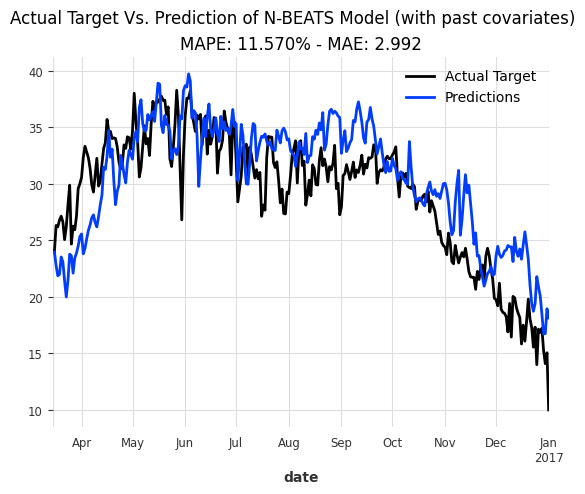

In [ ]:
target_val.plot(label ="Actual Target")
nbeats_preds2.plot(label ="Predictions")
plt.suptitle("Actual Target Vs. Prediction of N-BEATS Model (with past covariates)")
plt.title(f"MAPE: {mape(target_val, nbeats_preds2):.3f}% - MAE: {mae(target_val, nbeats_preds2):.3f}")

Adding past covariates (humidity, wind speed, and pressure) helped the N-BEATS model better align with the actual temperature series. Compared to the baseline (MAPE ≈ 16.44%, MAE ≈ 3.85°C), the model with covariates achieved lower errors (MAPE ≈ 11.57%, MAE ≈ 2.99°C), indicating improved short-term pattern recognition and more stable forecasts.

### Backtesting for N-BEATS Model

In [ ]:
# Run historical_forecasts
pred_series = nbeats_pastcov_model.historical_forecasts(
    series = full_target_scaled,
    past_covariates = full_past_cov_scaled,
    start= 0.6,
    forecast_horizon= 10,
    stride= 10,
    retrain= False,
)

In [ ]:
nbeats_backtest_forecasts = target_scaler.inverse_transform(pred_series)

# Compute error metrics
mae_backtest = mae(meantemp_timeseries, nbeats_backtest_forecasts)
mape_backtest = mape(meantemp_timeseries, nbeats_backtest_forecasts)

print()
print("Backtest results (historical forecasts) over validation period:")
print(f"MAE:  {mae_backtest: .3f}")
print(f"MAPE: {mape_backtest: .3f}")


Backtest results (historical forecasts) over validation period:
MAE:   1.921
MAPE:  7.530


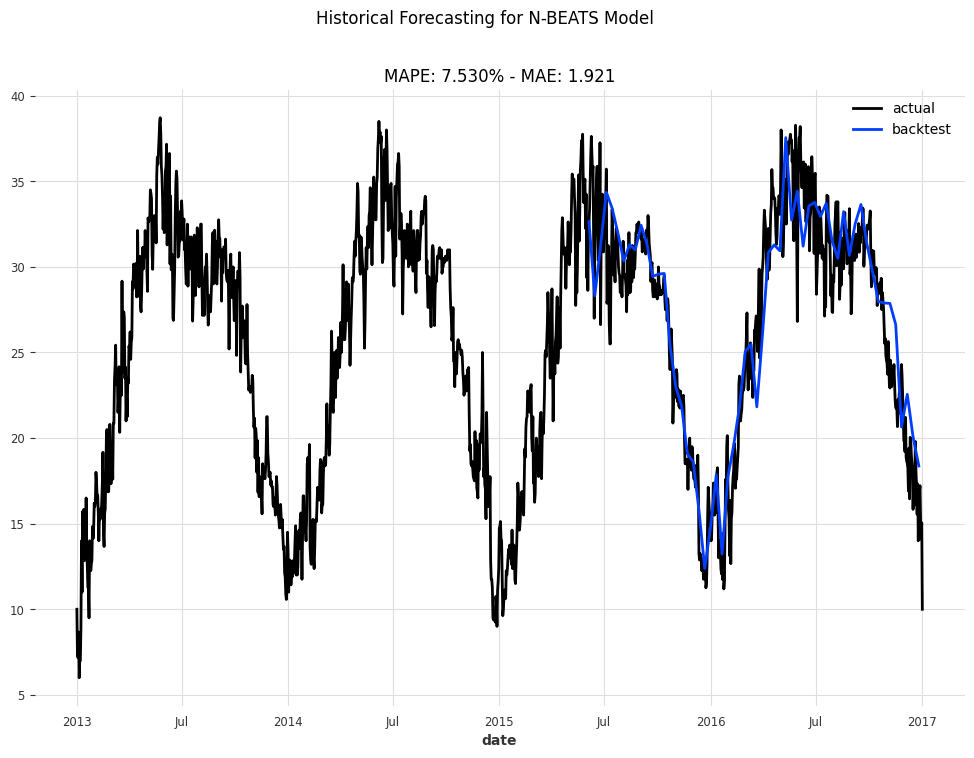

In [ ]:
plt.figure(figsize=(12,8))
meantemp_timeseries.plot(label="actual")

nbeats_backtest_forecasts.plot(label="backtest")

plt.suptitle("Historical Forecasting for N-BEATS Model")
plt.title(f"MAPE: {mape_backtest:.3f}% - MAE: {mae_backtest:.3f}")

plt.show()

This historical forecast plot shows the N-BEATS model's predictions using past covariates (humidity, wind speed, pressure). The model closely tracks the actual temperature series across seasons, achieving low error rates (MAPE ≈ 7.53%, MAE ≈ 1.92°C). This demonstrates the effectiveness of incorporating recent environmental variables to enhance forecast precision.

## TFT Forecasting

In this section, we apply the Temporal Fusion Transformer (TFT) model to forecast daily average temperature based on India’s climate time series. TFT is a powerful deep learning architecture designed for interpretable multi-horizon forecasting with support for static and time-varying covariates.

To tune the model, we performed a grid search over a small subset of hyperparameters. Since TFT models are computationally intensive and require long training times, we limited the search to just four combinations of `input_chunk_length` and `hidden_size`. All other parameters—such as output_chunk_length, dropout, num_attention_heads, n_epochs, and likelihood—were held constant across trials to reduce runtime and focus the search on key structural parameters.

This setup allows us to balance model accuracy with training efficiency while identifying a suitable configuration for climate forecasting.

#### Hyperparameter Tuning

In [ ]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
#early_stop = EarlyStopping(monitor="val_loss", patience=8, mode="min")

param_grid = {
    "input_chunk_length": [30, 60],        # lookback: ~1 or 2 months
    "hidden_size": [32, 64],

    # these args are constant across the gridsearch trials
    "output_chunk_length": [10],           # forecast_horizon
    "optimizer_kwargs": [{"lr": 1e-3}],
    "num_attention_heads": [4],
    "n_epochs": [15],
    "dropout": [0.1],
    "likelihood": [QuantileRegression(quantiles=quantiles)],
    "batch_size": [32],
    "random_state": [42]
}

# running gridsearch - expanding window mode
best_model, best_params, best_metric_score = TFTModel.gridsearch(
    parameters= param_grid,
    forecast_horizon = 10,
    series = target_train_scaled,
    future_covariates= future_cov,
    stride= 10,
    start=0.8,
    metric = mae,   # metric to optimize during grid search
    #verbose = True
)


In [ ]:
print("Best params:", best_params)
print("Best validation MAE (scaled):", best_score)

Best params: {'input_chunk_length': 30, 'hidden_size': 32, 'output_chunk_length': 10, 'optimizer_kwargs': {'lr': 0.001}, 'num_attention_heads': 4, 'n_epochs': 15, 'dropout': 0.1, 'likelihood': QuantileRegression(quantiles=[0.05, 0.25, 0.5, 0.75, 0.95], prior_strength=1.0), 'batch_size': 32, 'random_state': 42}
Best validation MAE (scaled): 0.05951410894088314


### 1. TFT Model with Future Covariates (Month & Season)

Using the tuned hyperparameters from the previous grid search, I trained a **Temporal Fusion Transformer (TFT)** baseline model using **only future covariates** (month and season). The model was trained for **100 epochs**, allowing it to learn seasonal patterns and temporal dependencies from the covariate signals alone, without relying on past target values.

In [ ]:
best_params.pop('n_epochs', None)

In [ ]:
tft_futcov_model = TFTModel(**best_params, n_epochs=100, force_reset=True)

tft_futcov_model.fit(target_train_scaled, future_covariates= future_cov_train)

In [ ]:
tft_preds = tft_futcov_model.predict(n=len(target_val_scaled), num_samples = 50, future_covariates= future_cov)

# Inverse transform
tft_preds = target_scaler.inverse_transform(tft_preds)

tft_futcov_mape = mape(target_val, tft_preds)
tft_futcov_mae = mae(target_val, tft_preds)

In [ ]:
# Evaluate
print("TFT Baseline Model(with only future covariates) MAPE:", tft_futcov_mape)
print("TFT Baseline Model(with only future covariates) MAE:", tft_futcov_mae)

TFT Baseline Model(with only future covariates) MAPE: 8.529223650634929
TFT Baseline Model(with only future covariates) MAE: 2.3043859207922424


The model achieved the following performance metrics on the validation set:

- **MAPE (Mean Absolute Percentage Error):** 8.52%
- **MAE (Mean Absolute Error):** 2.30°C

The prediction plot below shows a strong alignment between the **actual daily mean temperatures** (black line) and the **model’s forecasts** (blue line), with a well-behaved uncertainty band around the predictions.

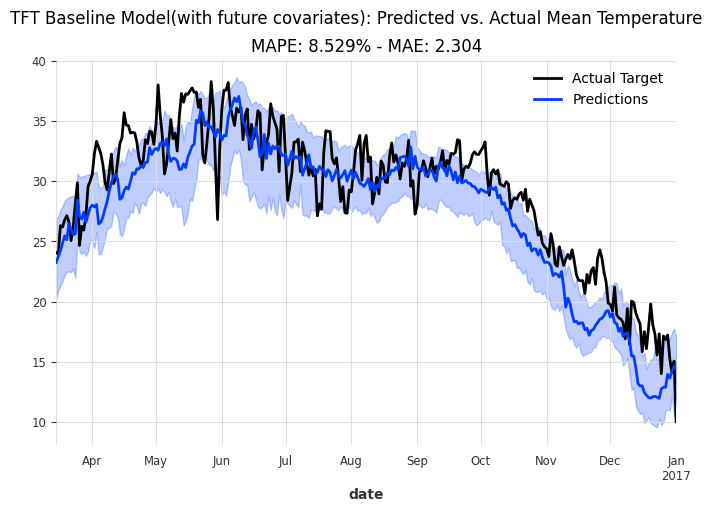

In [ ]:
plt.figure(figsize=(8, 5))

target_val.plot(label ="Actual Target")
tft_preds.plot(label ="Predictions", low_quantile= 0.05, high_quantile = 0.95)

plt.suptitle("TFT Baseline Model(with future covariates): Predicted vs. Actual Mean Temperature")
plt.title(f"MAPE: {mape(target_val, tft_preds):.3f}% - MAE: {mae(target_val, tft_preds):.3f}")

plt.show()

#### Performance Analysis

- A **MAPE under 9%** indicates that the model performs well even when limited to future covariates, capturing seasonal structure effectively.
- The **low MAE** confirms that the model’s absolute errors remain small and consistent across the year.
- The prediction curve closely follows the actual temperature trend, especially during seasonal transitions, suggesting that month and season covariates provide meaningful predictive signals.

Overall, the TFT baseline model demonstrates **strong performance and good generalization** on this time series.


### 2. TFT Model with Future + Past Covariates (Humidity, Wind Speed, Pressure)

In this step, We extended the TFT model by incorporating **past covariates** (humidity, wind speed, and pressure) alongside the existing future covariates (month and season). The model was trained for **100 epochs** using the same tuned hyperparameters from the previous grid search.

In [ ]:
tft_fut_past_cov_model = TFTModel(**best_params, n_epochs=100, force_reset=True)

tft_fut_past_cov_model.fit(target_train_scaled, future_covariates= future_cov_train , past_covariates= past_cov_train_scaled)

In [ ]:
tft_preds2 = tft_fut_past_cov_model.predict(n=len(target_val_scaled), num_samples = 50, future_covariates= future_cov , past_covariates= full_past_cov_scaled)

# Inverse transform
tft_preds2 = target_scaler.inverse_transform(tft_preds2)

tft_fut_past_cov_mape = mape(target_val, tft_preds2)
tft_fut_past_cov_mae = mae(target_val, tft_preds2)

In [ ]:
# Evaluate
print("TFT model(with past and future covariates) MAPE:", tft_fut_past_cov_mape)
print("TFT model(with past and future covariates) MAE:", tft_fut_past_cov_mae)

TFT model(with past and future covariates) MAPE: 8.783708368025275
TFT model(with past and future covariates) MAE: 2.490260798721442


The updated model achieved the following performance metrics:

- **MAPE (Mean Absolute Percentage Error):** 8.78%
- **MAE (Mean Absolute Error):** 2.49°C

The prediction plot below shows a close match between the **actual temperature values** and the **model’s forecasts**, with a stable uncertainty band throughout the year.

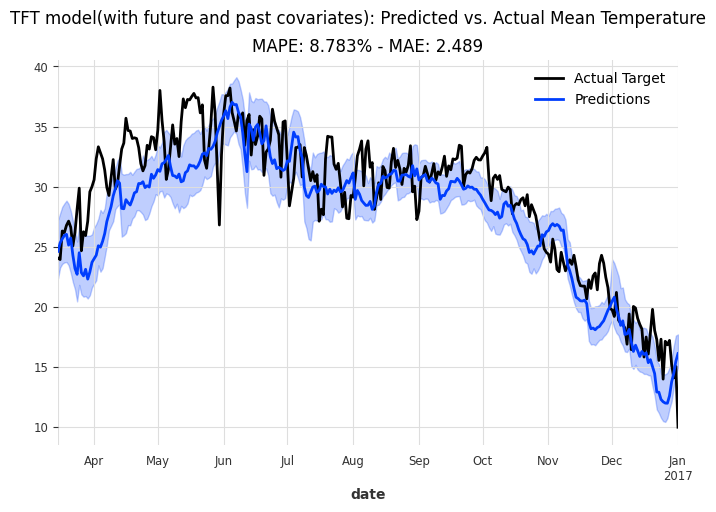

In [ ]:
plt.figure(figsize=(8, 5))

target_val.plot(label ="Actual Target")
tft_preds2.plot(label ="Predictions", low_quantile= 0.05, high_quantile = 0.95)

plt.suptitle("TFT model(with future and past covariates): Predicted vs. Actual Mean Temperature")
plt.title(f"MAPE: {mape(target_val, tft_preds2):.3f}% - MAE: {mae(target_val, tft_preds2):.3f}")

plt.show()

#### Performance Comparison

| Model Variant                          | MAPE (%) | MAE (°C) |
|----------------------------------------|----------|----------|
| TFT with only future covariates        | 8.52     | 2.30     |
| TFT with future + past covariates      | 8.78     | 2.49     |

- Despite adding informative past covariates, the model’s performance **did not improve** compared to the baseline version with only future covariates.
- The slight increase in error suggests that the added covariates may not provide additional predictive power for this specific target (mean temperature), or that the model already captured the seasonal structure effectively using month and season alone.
- It’s also possible that the inclusion of **humidity** and **wind speed** as past covariates introduced noise or redundancy, since their correlation with the target variable is relatively weak (~0.3). In contrast, the **mean pressure** covariate shows a strong negative correlation (-0.88) with mean temperature and is likely to contribute meaningful predictive signal.

#### Conclusion

While adding past covariates is theoretically beneficial, in this case the **baseline model with only future covariates performed slightly better**. Given that the `meanpressure_cleaned` column has a strong negative correlation with mean temperature (-0.88), it's unlikely to have introduced noise. Instead, the slight drop in performance may be due to the inclusion of **humidity** and **wind speed**, both of which show only moderate correlation (~0.3) with the target variable. These features might have added complexity without contributing meaningful predictive signal.


### Evaluating TFT Model via Backtesting

In this step, I applied **backtesting** to the TFT model trained with both future and past covariates. This method evaluates the model’s performance across multiple historical windows, providing a more robust assessment of its forecasting stability and generalization.

In [ ]:
# Run historical_forecasts
pred_series = tft_fut_past_cov_model.historical_forecasts(
    series = full_target_scaled,
    future_covariates = future_cov,
    past_covariates = full_past_cov_scaled,
    num_samples=50,
    start= 0.6,
    forecast_horizon= 10,
    stride= 10,
    retrain= False,
)

In [ ]:
tft_backtest_forecasts = target_scaler.inverse_transform(pred_series)

# Compute error metrics
mae_backtest = mae(meantemp_timeseries, tft_backtest_forecasts)
mape_backtest = mape(meantemp_timeseries, tft_backtest_forecasts)

print()
print("Backtest results (historical forecasts) over validation period:")
print(f"MAE:  {mae_backtest: .3f}")
print(f"MAPE: {mape_backtest: .3f}")


Backtest results (historical forecasts) over validation period:
MAE:   1.986
MAPE:  7.568


The plot below shows the actual temperature values versus the model’s historical forecasts, along with prediction intervals.

- **MAPE:** 7.57%
- **MAE:** 1.99°C

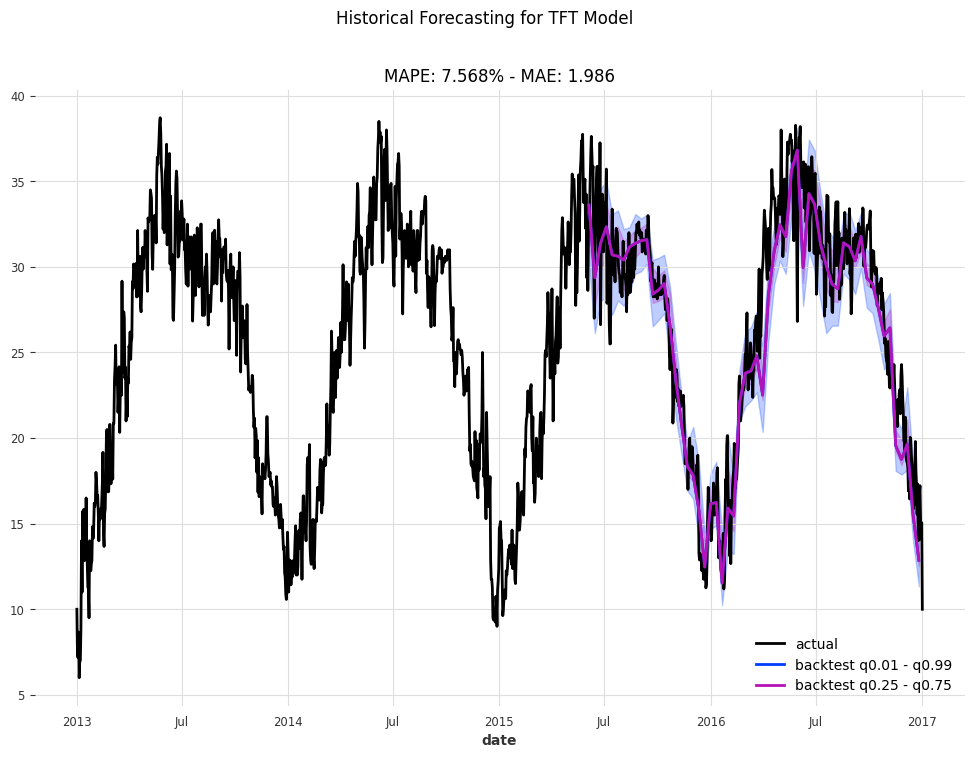

In [ ]:
plt.figure(figsize=(12,8))
meantemp_timeseries.plot(label="actual")

tft_backtest_forecasts.plot(label="backtest q0.01 - q0.99", low_quantile=0.05, high_quantile=0.95)
tft_backtest_forecasts.plot(label="backtest q0.25 - q0.75", low_quantile=0.25, high_quantile=0.75)

plt.suptitle("Historical Forecasting for TFT Model")
plt.title(f"MAPE: {mape_backtest:.3f}% - MAE: {mae_backtest:.3f}")

plt.show()

The model demonstrates consistent accuracy across time, with tight uncertainty bands and close alignment between predicted and actual values.


## Deep TCN Model

To tune the DeepTCN model, I performed a randomized grid search over a defined hyperparameter space.  
Instead of testing all possible combinations, I sampled 24 random configurations to reduce training time while still exploring a diverse set of model architectures. This approach helps identify a well-performing setup efficiently, balancing accuracy and computational cost.

#### Hyperparameter Tuning

In [ ]:
# --- PARAM GRID ---
param_grid = {
    "input_chunk_length": [30, 60],        # lookback: 1,2,3 months approx
    "kernel_size": [2, 3],
    "num_filters": [3, 8, 16],                # increasing capacity
    "num_layers": [3, 5],                      # depth -> affects receptive_field
    "dropout": [0.0, 0.1, 0.2],

    "batch_size": [32],
    "optimizer_kwargs": [{"lr": 1e-3}],
    "n_epochs": [20],
    "dilation_base": [2],                      # keep 2 (standard)
    "output_chunk_length": [10]
}


best_model, best_params, best_score = TCNModel.gridsearch(
    n_random_samples = 24, # number of hyperparameter combinations to select from the full parameter grid.
    forecast_horizon = 10,
    parameters = param_grid,
    series=target_train_scaled,
    stride= 10,
    start=0.8,
    metric = mae,
    verbose=True
)

### 1. DeepTCN Baseline Model (No Covariates)

In this step, I trained a baseline **Deep Temporal Convolutional Network (DeepTCN)** model using only the target series, without any past or future covariates. The model was trained for **100 epochs** using the best hyperparameters found during randomized grid search, and optimized with **quantile regression** to capture prediction uncertainty.

In [ ]:
best_params.pop('n_epochs', None)

20

In [ ]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]

deeptcn_baseline_model = TCNModel(**best_params, n_epochs=100, likelihood=QuantileRegression(quantiles=quantiles), force_reset=True)

deeptcn_baseline_model.fit(target_train_scaled)

In [ ]:
tcn_preds = deeptcn_baseline_model.predict(n=len(target_val_scaled), num_samples = 50)

# Inverse transform
tcn_preds = target_scaler.inverse_transform(tcn_preds)

tcn_mape = mape(target_val, tcn_preds)
tcn_mae = mae(target_val, tcn_preds)

In [ ]:
# Evaluate
print("TCN Baseline model MAPE:", tcn_mape)
print("TCN Baseline model MAE:", tcn_mae)

TCN Baseline model MAPE: 14.29897625345164
TCN Baseline model MAE: 3.4801185290719565


On the validation set, the model achieved:

- **MAPE:** 14.29%
- **MAE:** 3.48°C

The prediction plot below shows noticeable deviations between the actual and predicted temperature values, especially during seasonal transitions. The relatively high error metrics suggest that the model struggles to capture the full dynamics of the temperature series when covariates are excluded.

This baseline serves as a reference point to evaluate the added value of incorporating external features like humidity, pressure, and seasonal indicators in later stages.

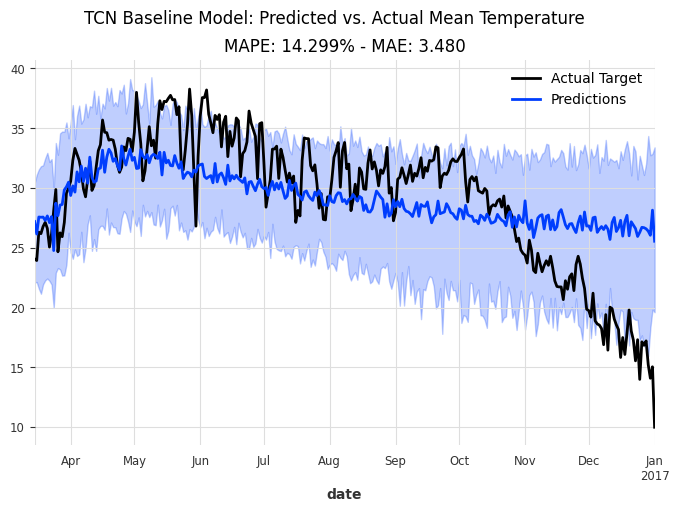

In [ ]:
plt.figure(figsize=(8, 5))

target_val.plot(label ="Actual Target")
tcn_preds.plot(label ="Predictions", low_quantile= 0.05, high_quantile = 0.95)

plt.suptitle("TCN Baseline Model: Predicted vs. Actual Mean Temperature")
plt.title(f"MAPE: {tcn_mape:.3f}% - MAE: {tcn_mae:.3f}")

plt.show()

### 2. DeepTCN Model with Past Covariates (Humidity, Wind Speed, Pressure)

In this step, I enhanced the DeepTCN model by incorporating **past covariates**—specifically humidity, wind speed, and pressure—alongside the target series. The model was trained for **100 epochs** using the same optimized hyperparameters and quantile regression to capture uncertainty.


In [ ]:
deeptcn_pastcov_model = TCNModel(**best_params, n_epochs=100, likelihood=QuantileRegression(quantiles=quantiles), force_reset=True)

deeptcn_pastcov_model.fit(target_train_scaled, past_covariates= past_cov_train_scaled)

In [ ]:
tcn_preds2 = deeptcn_pastcov_model.predict(n=len(target_val_scaled), past_covariates= full_past_cov_scaled, num_samples = 50)

# Inverse transform
tcn_preds2 = target_scaler.inverse_transform(tcn_preds2)

tcn_past_cov_mape = mape(target_val, tcn_preds2)
tcn_past_cov_mae = mae(target_val, tcn_preds2)

In [ ]:
# Evaluate
print("TCN Model(with past covariates) MAPE:", tcn_past_cov_mape)
print("TCN Model(with past covariates) MAE:", tcn_past_cov_mae)

TCN Model(with past covariates) MAPE: 11.238267740440719
TCN Model(with past covariates) MAE: 2.7802969461343445


On the validation set, the model achieved:

- **MAPE:** 11.23%
- **MAE:** 2.78°C

Compared to the baseline DeepTCN model trained without covariates (MAPE: 14.29%, MAE: 3.48°C), this version shows a **significant improvement in accuracy**.

The plot below compares the **actual mean temperature** values with the **predictions** made by the DeepTCN model using past covariates.  

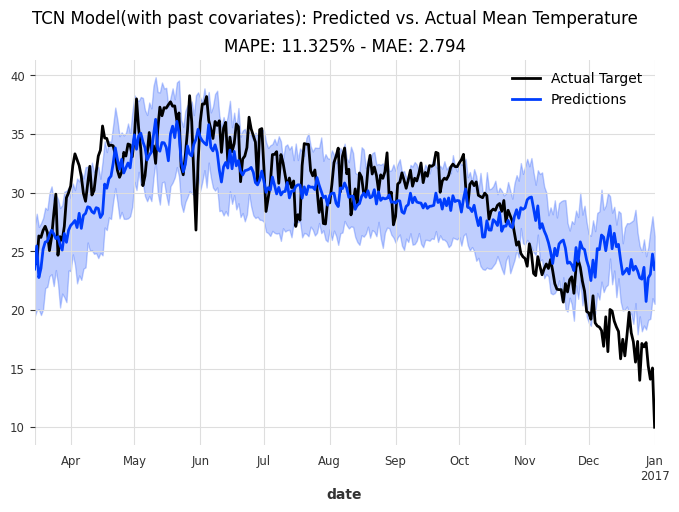

In [ ]:
plt.figure(figsize=(8, 5))

target_val.plot(label ="Actual Target")
tcn_preds2.plot(label ="Predictions", low_quantile= 0.05, high_quantile = 0.95)

plt.suptitle("TCN Model(with past covariates): Predicted vs. Actual Mean Temperature")
plt.title(f"MAPE: {tcn_past_cov_mape:.3f}% - MAE: {tcn_past_cov_mae:.3f}")

plt.show()

The plot below compares the **actual mean temperature** values with the **predictions** made by the DeepTCN model using past covariates.  

Visually, the model tracks seasonal trends and temperature fluctuations more closely than the baseline version. The prediction curve aligns more closely with the actual temperature values, especially during peak summer and winter periods, and the uncertainty band is narrower and remains stable throughout the year.

This visual confirms the quantitative improvement observed in the error metrics, highlighting the benefit of including relevant past covariates.


### Evaluating TCN Model via Backtesting

In this step, I applied backtesting to the TCN model trained with past covariates. This method evaluates the model’s performance across multiple historical windows, providing a more robust assessment of its forecasting stability and generalization.

To speed up the process, I set `retrain=False`, which reuses the already trained model instead of retraining it for each forecast window. This allows for faster evaluation while maintaining consistency in model parameters.


To speed up the process, I set `retrain=False`, which reuses the already trained model instead of retraining it for each forecast window. This allows for faster evaluation while maintaining consistency in model parameters.

The backtesting results offer insight into how well the model generalizes across different time segments and how stable its predictions are over extended periods.

In [ ]:
# Run historical_forecasts
pred_series = deeptcn_pastcov_model.historical_forecasts(
    series = full_target_scaled,
    past_covariates = full_past_cov_scaled,
    num_samples=50,
    start= 0.6,
    forecast_horizon= 10,
    stride= 10,
    retrain= False,
)

In [ ]:
deeptcn_backtest_forecasts = target_scaler.inverse_transform(pred_series)

# Compute error metrics
mae_backtest = mae(meantemp_timeseries, deeptcn_backtest_forecasts)
mape_backtest = mape(meantemp_timeseries, deeptcn_backtest_forecasts)

print()
print("Backtest results (historical forecasts) over validation period:")
print(f"MAE:  {mae_backtest: .3f}")
print(f"MAPE: {mape_backtest: .3f}")


Backtest results (historical forecasts) over validation period:
MAE:   2.366
MAPE:  9.090


The DeepTCN model demonstrated strong performance during backtesting, with a **MAPE of 9.09%** and **MAE of 2.37°C** over the validation period.  
The forecast closely tracks the actual temperature trends across multiple historical windows, and the uncertainty bands remain stable and well-calibrated.  
This indicates that the model generalizes well over time and maintains reliable accuracy in real-world forecasting scenarios.

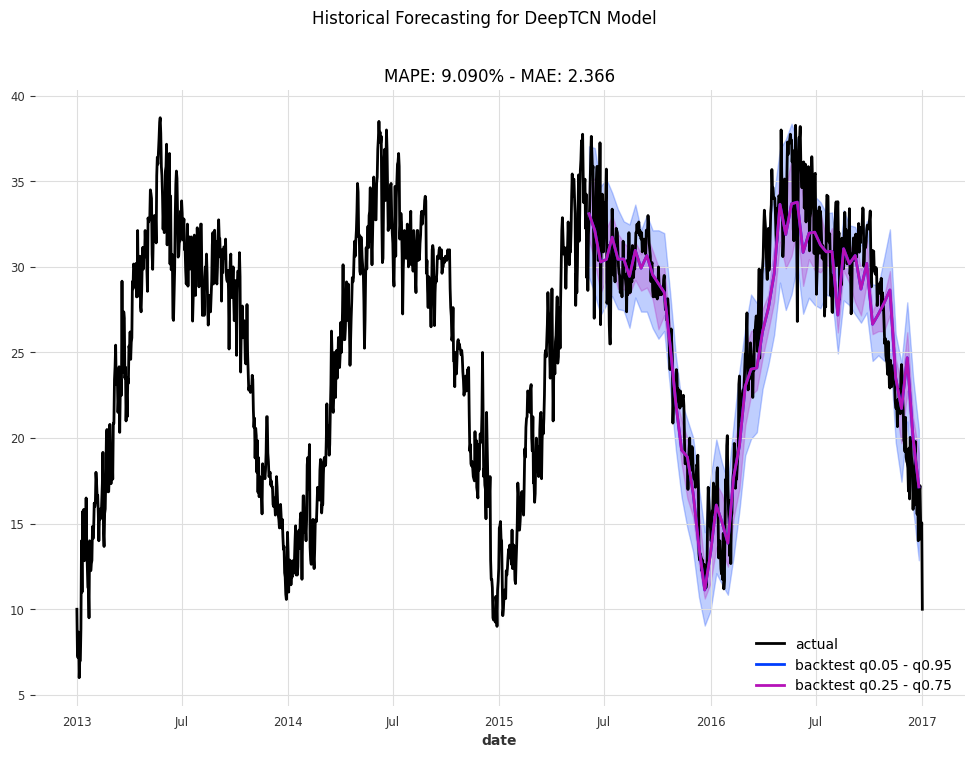

In [ ]:
plt.figure(figsize=(12,8))
meantemp_timeseries.plot(label="actual")

deeptcn_backtest_forecasts.plot(label="backtest q0.05 - q0.95", low_quantile=0.05, high_quantile=0.95)
deeptcn_backtest_forecasts.plot(label="backtest q0.25 - q0.75", low_quantile=0.25, high_quantile=0.75)

plt.suptitle("Historical Forecasting for DeepTCN Model")
plt.title(f"MAPE: {mape_backtest:.3f}% - MAE: {mae_backtest:.3f}")

plt.show()

## 📊 Comparison of Model Performance (MAE on Validation Set)

The table below compares the performance of four deep learning forecasting models — **DeepAR**, **N-BEATS**, **Temporal Fusion Transformer (TFT)**, and **DeepTCN** — under different covariate settings.  

| **Model / Covariates**                        | **No Covariates** | **Month & Season** | **Humidity, Wind Speed & Pressure** |
|----------------------------------------------|-------------------:|-------------------:|------------------------------------:|
| **DeepAR**                                   | 12.90              | 2.19               | —                                   |
| **N-BEATS**                                  | 3.85               | —                  | 2.99                                |
| **Temporal Fusion Transformer (TFT)**        | —                  | 2.304              | 2.49                                |
| **DeepTCN**                                  | 3.48               | —                  | 2.794                               |


### Notes on Model Compatibility with Covariates

Different deep learning forecasting models in Darts support different types of covariates, depending on their internal architectures.  
For this reason, some cells in the comparison table are marked with a dash (**—**) because those models cannot use certain types of covariates.

- **DeepAR**: Supports *future covariates* only. It is an autoregressive probabilistic RNN, so past covariates are implicitly captured by the target history itself.  
- **N-BEATS**: Accepts *past covariates* only. This model is fully connected and univariate by design, so it cannot incorporate any information from the future.  
- **Temporal Fusion Transformer (TFT)**: Requires *future covariates* mandatorily and can also take past covariates. The model architecture is designed to fuse temporal information from known future features through attention layers.  
- **DeepTCN**: Uses *past covariates* only, since the convolutional filters are causal and cannot access future information.

Therefore, some table entries are marked with “—” where the corresponding model does not support that type of covariate.


### 🔍 Comparative Analysis of Forecasting Models on Delhi Mean Temperature

Based on the results, the **DeepAR** model achieved the best overall performance when future covariates (month & season) were available, reaching an MAE of **≈ 2.20**. Without covariates, however, it performed poorly (MAE ≈ 12.9), showing that it strongly depends on known future inputs.

The **Temporal Fusion Transformer (TFT)** also delivered strong performance with MAE values around **2.30–2.49**, effectively capturing short-term temporal dynamics and seasonal variations when future covariates were available.

**N-BEATS** showed moderate accuracy (MAE ≈ 2.99–3.85), as it can only use past covariates and has no access to future information.  

**DeepTCN** also delivered decent results (MAE ≈ 2.79), though slightly worse than TFT, mainly because its causal convolutional structure prevents it from using future covariates.

Overall, the ranking of models based on their performance on the Delhi temperature series is:

> **DeepAR (with covariates) > TFT > DeepTCN > N-BEATS**